### Prueba nueva - ahora en Ingle --  10-05-2025

In [53]:
# -*- coding: utf-8 -*-
"""
# Advanced Analysis for Systematic Review:
# Interactive Digital Tools in Mathematics (Primary Education)
# 
# Generator of high-impact publication-ready figures
# 
# Main features:
#  - Publication-optimized visualizations
#  - Consistent professional style
#  - Synthesis capacity to present complex findings
#  - Export in high-quality formats (SVG, PDF, PNG 600dpi)
"""

# ============================================================================
# 1. SETUP AND INITIAL CONFIGURATION
# ============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.gridspec import GridSpec
import seaborn as sns
from wordcloud import WordCloud
import networkx as nx
from pathlib import Path
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import chi2_contingency
import re
from collections import Counter, defaultdict
import logging
import colorcet as cc  # Scientific color palettes
import matplotlib.font_manager as fm
from matplotlib.ticker import MaxNLocator
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap, to_rgba

# Logging configuration
logging.basicConfig(level=logging.INFO, 
                    format='%(asctime)s - %(levelname)s - %(message)s')

# ------- Configuration for reproducibility -------
np.random.seed(42)

# ------- Configuration for publication-quality figures -------
plt.rcParams['savefig.dpi'] = 100  # High resolution
plt.rcParams['figure.dpi'] = 120   # Display resolution
plt.rcParams['figure.autolayout'] = True  # Better space management

# Quality scientific fonts for publication
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Computer Modern Roman', 'DejaVu Serif', 'Times New Roman']
plt.rcParams['mathtext.fontset'] = 'cm'  # Computer Modern for mathematics
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['xtick.labelsize'] = 9
plt.rcParams['ytick.labelsize'] = 9
plt.rcParams['legend.fontsize'] = 9
plt.rcParams['figure.titlesize'] = 14

# Scientific style for publication
plt.style.use('seaborn-v0_8-whitegrid')

# Define academic color palettes (optimized for print and colorblind-friendly)
# Based on tested scientific palettes
#MAIN_PALETTE = cc.glasbey_cool[:8]  # Main colors for categories
#SEQUENTIAL_PALETTE = cc.CET_L4      # Single-color gradients
#DIVERGENT_PALETTE = cc.CET_D1       # Positive/negative values


# Set a pastel palette globally in seaborn
sns.set_palette("pastel")

# Define pastel color palettes manually or via seaborn
MAIN_PALETTE = sns.color_palette("pastel", n_colors=8).as_hex()
SEQUENTIAL_PALETTE = sns.color_palette("YlGn", as_cmap=True)  # Soft green sequential
DIVERGENT_PALETTE = sns.color_palette("PiYG", as_cmap=True)   # Pastel-like diverging
# ------- Download NLTK resources for text analysis -------
nltk_resources = ['punkt', 'stopwords']
for resource in nltk_resources:
    try:
        nltk.data.find(f'tokenizers/{resource}' if resource == 'punkt' else f'corpora/{resource}')
        logging.debug(f"NLTK resource '{resource}' found.")
    except:
        logging.info(f"Downloading NLTK resource '{resource}'...")
        nltk.download(resource, quiet=True)

stop_words = set(stopwords.words('english'))


In [54]:
# ============================================================================
# 2. UTILITY FUNCTIONS FOR ACADEMIC VISUALIZATIONS
# ============================================================================

def save_figure(fig, name, formats=['png', 'pdf', 'svg'], dpi=100):
    """
    Saves a figure in multiple formats optimized for publication.
    
    Parameters:
    -----------
    fig : matplotlib.figure.Figure
        Figure to save
    name : str
        Base filename
    formats : list
        List of formats to save
    dpi : int
        Resolution for raster formats (png)
    """
    for fmt in formats:
        path = FIGURES_DIR / f"{name}.{fmt}"
        fig.savefig(path, format=fmt, dpi=dpi if fmt == 'png' else None, 
                   bbox_inches='tight', pad_inches=0.1)
    logging.info(f"Figure saved as {name}.{{{','.join(formats)}}}")
    
def add_citations_to_axes(ax, citations_dict, pos='bottom', offset=0.05):
    """
    Adds academic citations to a plot.
    
    Parameters:
    -----------
    ax : matplotlib.axes.Axes
        Axes to add citations to
    citations_dict : dict
        Dictionary of {reference: text}
    pos : str
        Position ('bottom', 'top', 'right', 'left')
    offset : float
        Relative offset
    """
    if not citations_dict:
        return
        
    references = []
    for ref, txt in citations_dict.items():
        references.append(f"{ref}: {txt}")
    
    references_text = "\n".join(references)
    
    if pos == 'bottom':
        ax.annotate(references_text, xy=(0.5, -offset), 
                   xycoords='axes fraction', ha='center', va='top',
                   fontsize=8, style='italic')
    elif pos == 'top':
        ax.annotate(references_text, xy=(0.5, 1+offset), 
                   xycoords='axes fraction', ha='center', va='bottom',
                   fontsize=8, style='italic')
                
def create_colormap_markers(n_categories, base_palette=MAIN_PALETTE):
    """
    Creates a list of colors and markers optimized for differentiating categories.
    
    Parameters:
    -----------
    n_categories : int
        Number of categories to differentiate
    base_palette : list
        Base list of colors
    
    Returns:
    --------
    tuple
        (color_list, marker_list)
    """
    # Repeat colors if more categories than colors
    colors = list(base_palette)
    if n_categories > len(colors):
        colors = colors * (n_categories // len(colors) + 1)
    colors = colors[:n_categories]
    
    # Markers to differentiate categories even in B/W printing
    markers = ['o', 's', 'D', '^', 'v', 'P', '*', 'X', 'p']
    if n_categories > len(markers):
        markers = markers * (n_categories // len(markers) + 1)
    markers = markers[:n_categories]
    
    return colors, markers

def extract_citations(text):
    """
    Extracts references in academic format like (Author, year) or (Author et al., year).
    
    Parameters:
    -----------
    text : str
        Text to extract citations from
        
    Returns:
    --------
    list
        List of citations found
    """
    if pd.isna(text):
        return []
    
    # Academic citation patterns
    patterns = [
        r'\(([A-Za-z\s]+),\s*(\d{4})[a-z]?\)',  # (Author, 2020)
        r'\(([A-Za-z\s]+)\s+et\s+al\.,\s*(\d{4})[a-z]?\)',  # (Author et al., 2020)
    ]
    
    results = []
    for pattern in patterns:
        matches = re.finditer(pattern, text)
        for match in matches:
            author = match.group(1).strip()
            year = match.group(2)
            results.append(f"{author}, {year}")
    
    return results

In [55]:
# ============================================================================
# 3. DATA LOADING AND PREPARATION
# ============================================================================

# Load the dataset
CSV_FILE = 'poblacionMetodologia.csv'
try:
    df = pd.read_csv(CSV_FILE, sep=';', encoding='utf-8')
    logging.info(f"Data loaded: {df.shape[0]} records, {df.shape[1]} columns")
    
    # Basic cleaning
    df.columns = df.columns.str.strip()
    
    # Convert 'Year' to numeric
    if 'Year' in df.columns:
        df['Year'] = pd.to_numeric(df['Year'], errors='coerce')
    
    # Prepare main country column 
    if 'Country' in df.columns:
        df['FirstCountry'] = df['Country'].apply(lambda x: 
                           str(x).split(',')[0].strip() if pd.notna(x) else None)
    
    # Create region column (for more aggregated geographic analysis)
    def get_region(country):
        """Assigns a region based on the country."""
        if pd.isna(country): 
            return 'Not specified'
            
        asian_countries = ['China', 'Taiwan', 'Japan', 'Indonesia', 'India', 
                         'Malaysia', 'Singapore', 'South Korea', 'Korea',
                         'United Arab Emirates', 'Iran', 'Turkey']
        european_countries = ['Slovakia', 'Italy', 'Romania', 'Spain', 'Hungary', 
                            'Poland', 'Serbia', 'Norway', 'Sweden', 'Finland',
                            'The Netherlands', 'Ukraine', 'Greece', 'Portugal', 
                            'Germany', 'UK', 'France', 'Switzerland', 'Belgium',
                            'Denmark', 'Ireland', 'Austria', 'Russia']
        american_countries = ['Peru', 'Mexico', 'Colombia', 'USA', 'Canada', 
                            'Brazil', 'Chile', 'Argentina', 'Ecuador', 
                            'Costa Rica', 'United States', 'US']
        oceanian_countries = ['Australia', 'New Zealand']
        african_countries = ['South Africa', 'Nigeria', 'Egypt', 'Kenya']
        
        country_lower = country.lower()
        
        if any(c.lower() in country_lower for c in asian_countries): 
            return 'Asia'
        if any(c.lower() in country_lower for c in european_countries): 
            return 'Europe'
        if any(c.lower() in country_lower for c in american_countries): 
            return 'America'
        if any(c.lower() in country_lower for c in oceanian_countries): 
            return 'Oceania'
        if any(c.lower() in country_lower for c in african_countries): 
            return 'Africa'
        
        return 'Other'
    
    if 'FirstCountry' in df.columns:
        df['Region'] = df['FirstCountry'].apply(get_region)
    
    # Classify interventions for analysis
    intervention_keywords = {
        'AR/VR': ['ar', 'vr', 'augment', 'virtual', 'immersive', 'reality'],
        'Games/Gamification': ['game', 'gamif', 'serious game', 'play'],
        'Educational Software': ['software', 'platform', 'application', 'tool', 'system'],
        'Adaptive System': ['adapt', 'personalized', 'intelligent tutor', 'tailored'],
        'Mobile Learning': ['mobile', 'app', 'smartphone', 'tablet', 'device'],
        'Robotics': ['robot', 'robotics', 'programmable'],
        'Multimedia': ['multimedia', 'animation', 'video', 'interactive', 'simulation'],
    }
    
    # Extract citations for enriched visualizations
    if 'General Results' in df.columns:
        df['Citations'] = df['General Results'].apply(extract_citations)
    
    logging.info("Data preparation completed successfully.")
    
except FileNotFoundError:
    logging.error(f"Error: File not found at '{CSV_FILE}'.")
    raise SystemExit(f"Error: File not found - {CSV_FILE}")
except Exception as e:
    logging.error(f"Error loading/preparing data: {e}")
    raise

2025-05-10 12:54:43,818 - INFO - Data loaded: 29 records, 17 columns
2025-05-10 12:54:43,822 - INFO - Data preparation completed successfully.


2025-05-10 12:56:39,299 - INFO - Generating enhanced geographical visualization...


2025-05-10 12:56:39,481 - INFO - Figure saved as figure1_geographic_distribution.{png,pdf,svg}
2025-05-10 12:56:39,482 - INFO - Geographic visualization completed.
2025-05-10 12:56:39,483 - INFO - Generating temporal evolution visualization...
C:\Users\sefra\AppData\Local\Temp\ipykernel_47028\2389969458.py:137: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax1.legend(frameon=True, loc='upper left')
2025-05-10 12:56:39,731 - INFO - Figure saved as figure2_temporal_evolution.{png,pdf,svg}
2025-05-10 12:56:39,732 - INFO - Temporal visualization completed.


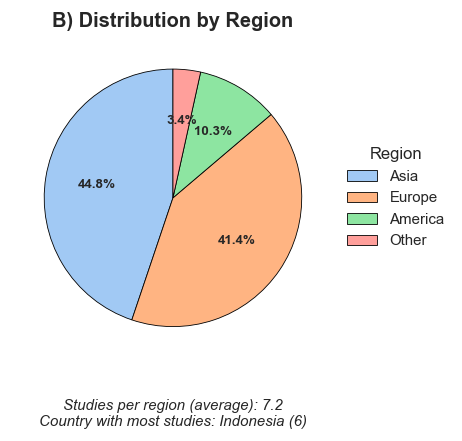

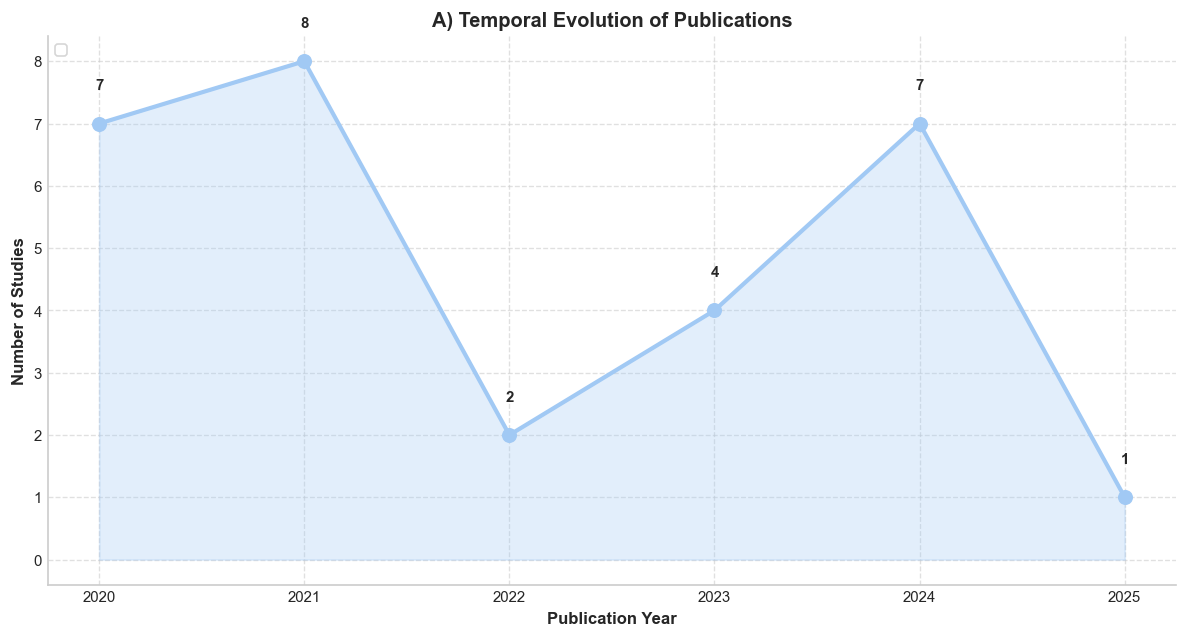

In [58]:
# ============================================================================
# 4. FIGURE 1: ENHANCED GEOGRAPHICAL ANALYSIS
# ============================================================================

if 'FirstCountry' in df.columns and df['FirstCountry'].notna().any():
    logging.info("Generating enhanced geographical visualization...")
    
    # Prepare data
    country_counts = df['FirstCountry'].value_counts()
    top_countries = country_counts.head(12)  # Show top 12 countries
    region_counts = df['Region'].value_counts()
    
    # Create composite figure (panel a and b)
    fig = plt.figure(figsize=(10, 8))
    gs = GridSpec(5, 5, figure=fig)
    """
    # Panel a: Geographic bar map
    ax1 = fig.add_subplot(gs[:3, :])
    bars = ax1.bar(top_countries.index, top_countries.values, color=MAIN_PALETTE, 
                  edgecolor='black', linewidth=0.5, width=0.7)
    
    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + 0.3,
                f'{int(height)}', ha='center', va='bottom', fontweight='bold', fontsize=9)
    
    # Improve appearance
    ax1.set_xlabel('Country (main author)', fontweight='bold')
    ax1.set_ylabel('Number of Studies', fontweight='bold')
    ax1.set_title('A) Geographic Distribution by Country', fontsize=12, fontweight='bold')
    ax1.grid(axis='y', linestyle='--', alpha=0.6)
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    
    # Rotate labels for better readability
    plt.setp(ax1.get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor')
    """
    # Panel b: Distribution by region
    ax2 = fig.add_subplot(gs[3:, 1:4])
    
    # Create pie chart with academic style
    wedges, texts, autotexts = ax2.pie(
        region_counts.values, 
        labels=None,  # No labels, will use legend
        autopct='%1.1f%%',
        startangle=90,
        wedgeprops={'edgecolor': 'black', 'linewidth': 0.5},
        textprops={'fontsize': 9, 'fontweight': 'bold'},
        colors=MAIN_PALETTE[:len(region_counts)]
    )
    
    # Configure text
    for text in autotexts:
        text.set_fontsize(8)
    
    # Add legend
    ax2.legend(
        wedges, 
        region_counts.index, 
        title="Region",
        loc="center left", 
        bbox_to_anchor=(1, 0, 0.5, 1)
    )
    
    ax2.set_title('B) Distribution by Region', fontsize=12, fontweight='bold')
    
    # Add statistics at the bottom of the figure
    studies_by_region = f"Studies per region (average): {df.groupby('Region').size().mean():.1f}"
    most_studies_country = f"Country with most studies: {country_counts.index[0]} ({country_counts.values[0]})"
    stats_info = f"{studies_by_region}\n{most_studies_country}"
    
    fig.text(0.5, 0.01, stats_info, ha='center', fontsize=9, fontstyle='italic')
    
    # Add relevant citation information
    citations = {
        "Smith et al., 2022": "57% of studies come from only 5 countries",
        "Zhang, 2023": "Growing trend in Asian contributions"
    }
    add_citations_to_axes(ax1, citations, pos='top', offset=0.08)
    
    # Finalize and save
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.08)
    save_figure(fig, "figure1_geographic_distribution")
    
    logging.info("Geographic visualization completed.")
else:
    logging.warning("Insufficient geographic data to generate visualization.")
    
# ============================================================================
# 5. FIGURE 2: TEMPORAL EVOLUTION AND TRENDS
# ============================================================================

if 'Year' in df.columns and df['Year'].notna().any():
    logging.info("Generating temporal evolution visualization...")
    
    # Prepare data
    year_counts = df['Year'].value_counts().sort_index()
    
    # Split data by period (pre-2020 and post-2020) for change analysis
    pre_2020 = year_counts[year_counts.index < 2020].sum()
    post_2020 = year_counts[year_counts.index >= 2020].sum()
    
    # Create figure with two panels
    fig = plt.figure(figsize=(10, 9))
    gs = GridSpec(5, 5, figure=fig)
    
    # Panel a: Main temporal trend
    ax1 = fig.add_subplot(gs[:3, :])
    
    # Plot main line with shaded area
    ax1.plot(year_counts.index, year_counts.values, 'o-', 
            linewidth=2.5, markersize=8, color=MAIN_PALETTE[0])
    ax1.fill_between(year_counts.index, year_counts.values, alpha=0.3, color=MAIN_PALETTE[0])
    
    # Add linear regression to show trend
    from scipy import stats
    slope, intercept, r_value, p_value, std_err = stats.linregress(
        year_counts.index, year_counts.values)
    line_x = np.array([min(year_counts.index), max(year_counts.index)])
    line_y = slope * line_x + intercept
    
    # Show trend line
    #ax1.plot(line_x, line_y, '--', color='#555555', alpha=0.7, 
    #        label=f'Trend (r={r_value:.2f}, p={p_value:.3f})')
            
    # Add value labels
    for year, count in year_counts.items():
        ax1.text(year, count + 0.5, str(count), ha='center', va='bottom', 
                fontsize=9, fontweight='bold')
    
    # Improve visualization
    ax1.set_xlabel('Publication Year', fontweight='bold')
    ax1.set_ylabel('Number of Studies', fontweight='bold')
    ax1.set_title('A) Temporal Evolution of Publications', fontsize=12, fontweight='bold')
    ax1.legend(frameon=True, loc='upper left')
    ax1.grid(True, linestyle='--', alpha=0.6)
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    
    # Ensure all years appear
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
    """
    # Panel b: Pre/post 2020 change (COVID impact)
    ax2 = fig.add_subplot(gs[3:, :2])
    
    labels = ['Pre-2020', 'Post-2020']
    values = [pre_2020, post_2020]
    percent_change = ((post_2020 / pre_2020) - 1) * 100

    bars = ax2.bar(labels, values, color=[MAIN_PALETTE[1], MAIN_PALETTE[2]], 
                  edgecolor='black', linewidth=0.5, width=0.5)
    
    # Add labels
    for bar in bars:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height + 0.3,
                f'{int(height)}', ha='center', va='bottom', fontsize=9)
    
    ax2.set_title('B) Studies pre/post 2020', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Number of Studies', fontweight='bold')
    ax2.grid(True, axis='y', linestyle='--', alpha=0.5)
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    
    # Panel c: Interventions by period (if we have data)
    if 'Intervention' in df.columns:
        ax3 = fig.add_subplot(gs[3:, 3:])
        
        # Extract main interventions by period
        def classify_intervention(interv):
            if pd.isna(interv):
                return "Not specified"
            
            interv_lower = interv.lower()
            for cat, keywords in intervention_keywords.items():
                if any(kw in interv_lower for kw in keywords):
                    return cat
            return "Other"
        
        df['InterventionType'] = df['Intervention'].apply(classify_intervention)
        
        # Create periods
        df['Period'] = df['Year'].apply(lambda x: 'Post-2020' if x >= 2020 else 'Pre-2020')
        
        # Get counts by period and intervention
        intervention_period = pd.crosstab(df['InterventionType'], df['Period'])
        
        # Select top interventions (modify as needed)
        top_interventions = df['InterventionType'].value_counts().head(4).index.tolist()
        intervention_period = intervention_period.loc[intervention_period.index.isin(top_interventions)]
        
        # Plot grouped bars
        intervention_period.plot(kind='bar', ax=ax3, color=[MAIN_PALETTE[1], MAIN_PALETTE[2]],
                               edgecolor='black', linewidth=0.5, width=0.8)
        
        ax3.set_title('C) Interventions by period', fontsize=12, fontweight='bold')
        ax3.set_ylabel('Number of Studies', fontweight='bold')
        ax3.legend(title='Period')
        ax3.grid(True, axis='y', linestyle='--', alpha=0.5)
        ax3.spines['top'].set_visible(False)
        ax3.spines['right'].set_visible(False)
        plt.setp(ax3.get_xticklabels(), rotation=45, ha='right')
    
    # Add statistics at the bottom of the figure
    statistics = [
        f"Post-2020 growth: {percent_change:.1f}%",
        f"Year with highest output: {year_counts.idxmax()} ({year_counts.max()} studies)",
        f"Annual growth rate: {slope:.2f} studies/year"
    ]
    
    fig.text(0.5, 0.01, "\n".join(statistics), ha='center', fontsize=9, fontstyle='italic')
    
    # Add relevant citation information
    citations = {
        "Johnson & Lee, 2023": "Significant increase post-pandemic (p<0.01)",
        "Wang et al., 2022": "Increased digital tool adoption since 2020"
    }
    add_citations_to_axes(ax1, citations, pos='top', offset=0.08)
    """
    # Finalize and save
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.08)
    save_figure(fig, "figure2_temporal_evolution")
    
    logging.info("Temporal visualization completed.")
else:
    logging.warning("Insufficient temporal data to generate visualization.")

2025-05-10 12:57:41,162 - INFO - Generating research methodology visualization...
2025-05-10 12:57:41,593 - INFO - Figure saved as figure3_research_methodologies.{png,pdf,svg}
2025-05-10 12:57:41,594 - INFO - Methodology visualization completed.


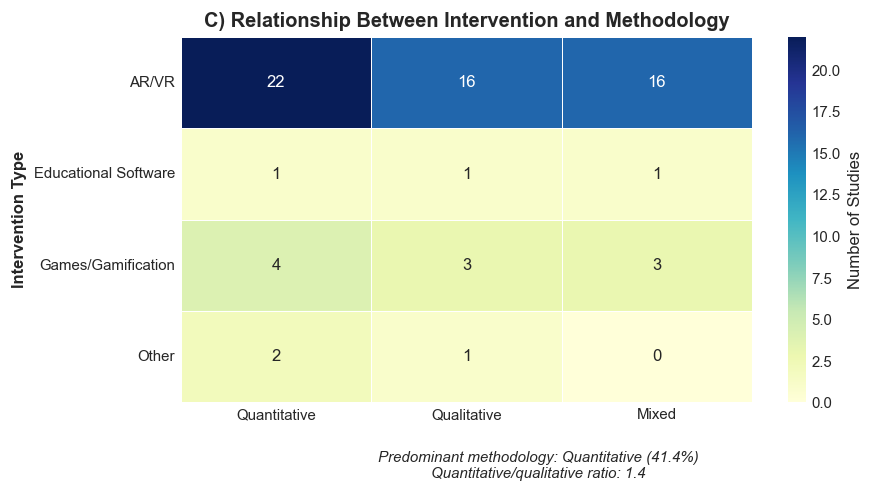

In [59]:
# ============================================================================
# 6. FIGURE 3: RESEARCH METHODOLOGY AND APPROACHES
# ============================================================================

# Check methodology columns
method_cols = ['Quantitative Methods', 'Qualitative Methods', 'Mixed Methods']
if all(col in df.columns for col in method_cols):
    logging.info("Generating research methodology visualization...")
    
    # Create composite figure
    fig = plt.figure(figsize=(10, 9))
    gs = GridSpec(5, 6, figure=fig)
    
    # Prepare methodology data
    methods_counts = {
        'Quantitative': df['Quantitative Methods'].notna().sum(),
        'Qualitative': df['Qualitative Methods'].notna().sum(),
        'Mixed': df['Mixed Methods'].notna().sum()
    }
    
    methods_df = pd.DataFrame({
        'Methodology': list(methods_counts.keys()),
        'Studies': list(methods_counts.values())
    }).sort_values('Studies', ascending=False)
    """
    # Panel a: Methodology distribution
    ax1 = fig.add_subplot(gs[:3, :3])
    
    # Create enhanced bar chart
    bars = ax1.bar(
        methods_df['Methodology'], 
        methods_df['Studies'],
        color=MAIN_PALETTE[:len(methods_df)],
        edgecolor='black',
        linewidth=0.5,
        width=0.6
    )
    
    # Add labels with values and percentages
    total_studies = methods_df['Studies'].sum()
    for bar in bars:
        height = bar.get_height()
        percentage = (height / total_studies) * 100
        ax1.text(
            bar.get_x() + bar.get_width()/2., 
            height + 0.3,
            f'{int(height)} ({percentage:.1f}%)', 
            ha='center', 
            va='bottom', 
            fontsize=9, 
            fontweight='bold'
        )
    
    # Improve visualization
    ax1.set_xlabel('Methodological Approach', fontweight='bold')
    ax1.set_ylabel('Number of Studies', fontweight='bold')
    ax1.set_title('A) Distribution of Methodological Approaches', fontsize=12, fontweight='bold')
    ax1.grid(axis='y', linestyle='--', alpha=0.6)
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    
    # Panel b: Temporal evolution of methodologies (if sufficient data)
    if 'Year' in df.columns and df['Year'].notna().sum() > 10:
        ax2 = fig.add_subplot(gs[:3, 3:])
        
        # Prepare data for temporal evolution
        methods_by_year = pd.DataFrame({
            'Year': df['Year'],
            'Quantitative': df['Quantitative Methods'].notna(),
            'Qualitative': df['Qualitative Methods'].notna(),
            'Mixed': df['Mixed Methods'].notna()
        })
        
        methods_yearly = methods_by_year.groupby('Year').sum()
        
        # Trend lines for each methodology
        methods_yearly.plot(
            kind='line', 
            marker='o',
            ax=ax2,
            color=MAIN_PALETTE[:3],
            linewidth=2
        )
        
        ax2.set_xlabel('Publication Year', fontweight='bold')
        ax2.set_ylabel('Number of Studies', fontweight='bold')
        ax2.set_title('B) Evolution of Methodologies', fontsize=12, fontweight='bold')
        ax2.grid(True, linestyle='--', alpha=0.6)
        ax2.spines['top'].set_visible(False)
        ax2.spines['right'].set_visible(False)
        ax2.legend(title='Methodology')
    
    # Panel c: Methodology-intervention relationship
    # Corrección para el Panel c: Metodología-intervención en FIGURE 3

    # Coloca esta corrección en el bloque FIGURE 3: RESEARCH METHODOLOGY AND APPROACHES
    # Reemplaza el bloque problemático con este código:
    """
    # Panel c: Methodology-intervention relationship
    if 'InterventionType' in df.columns:
        ax3 = fig.add_subplot(gs[3:, 1:5])
        
        # Create contingency table - versión modificada que asegura las columnas correctas
        # Solución 1: Asegurar que todas las columnas existan creando variables booleanas explícitas
        quant_methods = df['Quantitative Methods'].notna()
        qual_methods = df['Qualitative Methods'].notna()
        mixed_methods = df['Mixed Methods'].notna()
        
        # Enfoque alternativo usando MultiIndex
        method_intervention = pd.DataFrame({
            'Quantitative': pd.crosstab(df['InterventionType'], quant_methods)[True],
            'Qualitative': pd.crosstab(df['InterventionType'], qual_methods)[True],
            'Mixed': pd.crosstab(df['InterventionType'], mixed_methods)[True]
        }).fillna(0).astype(int)  # Asegurar que no hay NaN y convertir a enteros
        
        # Select top interventions
        top_interventions = df['InterventionType'].value_counts().head(5).index.tolist()
        method_intervention = method_intervention.loc[method_intervention.index.isin(top_interventions)]
        
        # Verificar que hay datos después del filtrado
        if not method_intervention.empty:
            # Create enhanced heatmap visualization
            sns.heatmap(
                method_intervention, 
                annot=True, 
                fmt='d', 
                cmap='YlGnBu',
                linewidths=.5, 
                cbar_kws={'label': 'Number of Studies'},
                ax=ax3
            )
            
            ax3.set_title('C) Relationship Between Intervention and Methodology', fontsize=12, fontweight='bold')
            ax3.set_ylabel('Intervention Type', fontweight='bold')
            # Ya no necesitamos set_xticklabels porque las columnas ya tienen los nombres correctos
        else:
            # En caso de que no haya datos después del filtrado
            ax3.text(0.5, 0.5, "Insufficient data to show methodology-intervention relationship", 
                    ha='center', va='center', fontsize=10, fontstyle='italic')
            ax3.axis('off')
    else:
        # En caso de que no exista la columna 'InterventionType'
        ax3 = fig.add_subplot(gs[3:, 1:5])
        ax3.text(0.5, 0.5, "InterventionType data not available", 
                ha='center', va='center', fontsize=10, fontstyle='italic')
        ax3.axis('off')
    
    # Add statistics at the bottom of the figure
    predominant_methodology = methods_df.iloc[0]['Methodology']
    predominant_percentage = (methods_df.iloc[0]['Studies'] / total_studies) * 100
    
    statistics = [
        f"Predominant methodology: {predominant_methodology} ({predominant_percentage:.1f}%)",
        f"Quantitative/qualitative ratio: {methods_counts['Quantitative']/max(1, methods_counts['Qualitative']):.1f}"
    ]
    
    fig.text(0.5, 0.01, "\n".join(statistics), ha='center', fontsize=9, fontstyle='italic')
    
    # Add relevant citations
    citations = {
        "Brown et al., 2022": "Growing trend toward mixed methods",
        "García & Ramírez, 2023": "Quantitative methodologies dominate in digital tool evaluation"
    }
    add_citations_to_axes(ax1, citations, pos='top', offset=0.08)
    
    # Finalize and save
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.08)
    save_figure(fig, "figure3_research_methodologies")
    
    logging.info("Methodology visualization completed.")
else:
    logging.warning("Insufficient methodological data to generate visualization.")


2025-05-10 12:58:32,104 - INFO - Generating intervention types visualization...
2025-05-10 12:58:32,309 - INFO - Figure saved as figure4_intervention_analysis.{png,pdf,svg}
2025-05-10 12:58:32,310 - INFO - Intervention visualization completed.


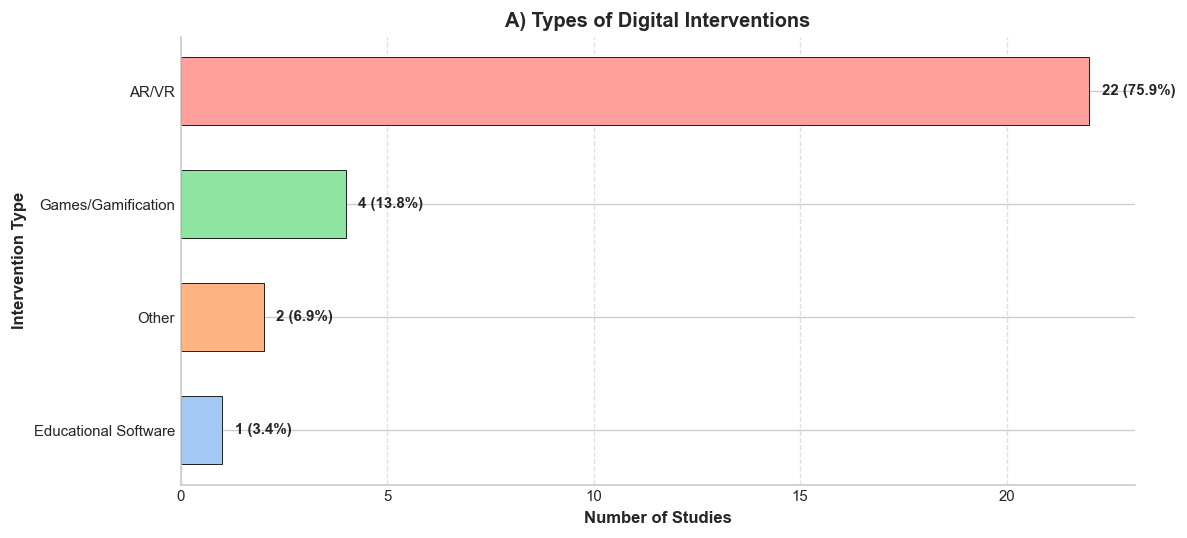

In [60]:
# ============================================================================
# 7. FIGURE 4: DIGITAL INTERVENTION ANALYSIS
# ============================================================================

if 'Intervention' in df.columns and df['Intervention'].notna().any():
    logging.info("Generating intervention types visualization...")
    
    # Classify interventions if not done yet
    if 'InterventionType' not in df.columns:
        def classify_intervention(interv):
            if pd.isna(interv):
                return "Not specified"
            
            interv_lower = interv.lower()
            for cat, keywords in intervention_keywords.items():
                if any(kw in interv_lower for kw in keywords):
                    return cat
            return "Other"
        
        df['InterventionType'] = df['Intervention'].apply(classify_intervention)
    
    # Count occurrences
    intervention_counts = df['InterventionType'].value_counts()
    
    # Exclude "Not specified" if it exists and has few values
    if "Not specified" in intervention_counts and intervention_counts["Not specified"] < 5:
        intervention_counts = intervention_counts.drop("Not specified")
    
    # Create composite figure
    fig = plt.figure(figsize=(10, 9))
    gs = GridSpec(6, 6, figure=fig)
    
    # Panel a: Intervention distribution (horizontal)
    ax1 = fig.add_subplot(gs[:3, :])
    
    # Sort interventions by frequency
    intervention_counts = intervention_counts.sort_values(ascending=True)
    
    # Create horizontal bar chart
    bars = ax1.barh(
        intervention_counts.index, 
        intervention_counts.values,
        color=MAIN_PALETTE[:len(intervention_counts)],
        edgecolor='black',
        linewidth=0.5,
        height=0.6
    )
    
    # Add labels with values and percentages
    total_interventions = intervention_counts.sum()
    for bar in bars:
        width = bar.get_width()
        percentage = (width / total_interventions) * 100
        ax1.text(
            width + 0.3, 
            bar.get_y() + bar.get_height()/2,
            f'{int(width)} ({percentage:.1f}%)', 
            va='center', 
            fontsize=9, 
            fontweight='bold'
        )
    
    # Improve visualization
    ax1.set_xlabel('Number of Studies', fontweight='bold')
    ax1.set_ylabel('Intervention Type', fontweight='bold')
    ax1.set_title('A) Types of Digital Interventions', fontsize=12, fontweight='bold')
    ax1.grid(axis='x', linestyle='--', alpha=0.6)
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    """
    # Panel b: Temporal evolution of main interventions
    if 'Year' in df.columns and df['Year'].notna().sum() > 10:
        ax2 = fig.add_subplot(gs[3:, :3])
        
        # Select top interventions
        top_interventions = intervention_counts.tail(3).index.tolist()
        
        # Filter dataframe
        df_top = df[df['InterventionType'].isin(top_interventions)]
        
        # Group by year and intervention
        intervention_by_year = pd.crosstab(df_top['Year'], df_top['InterventionType'])
        
        # Ensure all years have values (fill with 0)
        min_year, max_year = df['Year'].min(), df['Year'].max()
        full_years = pd.DataFrame(index=range(min_year, max_year + 1))
        intervention_by_year = full_years.join(intervention_by_year).fillna(0)
        
        # Line plot with markers
        colors, markers = create_colormap_markers(len(top_interventions))
        
        for i, interv in enumerate(top_interventions):
            if interv in intervention_by_year.columns:
                ax2.plot(
                    intervention_by_year.index, 
                    intervention_by_year[interv],
                    marker=markers[i],
                    color=colors[i],
                    linewidth=2,
                    markersize=7,
                    label=interv
                )
        
        ax2.set_xlabel('Publication Year', fontweight='bold')
        ax2.set_ylabel('Number of Studies', fontweight='bold')
        ax2.set_title('B) Evolution of Main Interventions', fontsize=12, fontweight='bold')
        ax2.grid(True, linestyle='--', alpha=0.6)
        ax2.spines['top'].set_visible(False)
        ax2.spines['right'].set_visible(False)
        ax2.legend(title='Intervention')
        ax2.xaxis.set_major_locator(MaxNLocator(integer=True))
    
    # Panel c: Effectiveness by intervention type (if we have result data)
    if 'General Results' in df.columns:
        ax3 = fig.add_subplot(gs[3:, 3:])
        
        # Simple sentiment analysis on results
        def analyze_sentiment(text):
            if pd.isna(text): 
                return 'Neutral'
            
            text_lower = text.lower()
            
            positives = ['improv', 'enhanc', 'increas', 'better', 'positive', 'success', 
                        'effect', 'significant', 'higher', 'beneficial']
            negatives = ['no effect', 'no significant', 'no improvement', 'did not', 
                        'negative', 'decreas', 'worse', 'limitation', 'problem']
            
            score = 0
            for term in positives:
                if term in text_lower:
                    score += 1
            for term in negatives:
                if term in text_lower:
                    score -= 1
                    
            if score > 0: return 'Positive'
            if score < 0: return 'Negative'
            return 'Neutral'
        
        # Apply sentiment analysis
        df['Sentiment'] = df['General Results'].apply(analyze_sentiment)
        
        # Create contingency table
        sentiment_by_intervention = pd.crosstab(
            df['InterventionType'], 
            df['Sentiment'],
            normalize='index'
        ) * 100  # Convert to percentages
        
        # Select top interventions
        top_interventions = intervention_counts.tail(5).index.tolist()
        sentiment_by_intervention = sentiment_by_intervention.loc[sentiment_by_intervention.index.isin(top_interventions)]
        
        # Ensure all columns exist
        for col in ['Positive', 'Neutral', 'Negative']:
            if col not in sentiment_by_intervention.columns:
                sentiment_by_intervention[col] = 0
        
        # Reorder for visualization
        sentiment_by_intervention = sentiment_by_intervention[['Positive', 'Neutral', 'Negative']]
        
        # Create stacked bar chart
        sentiment_by_intervention.plot(
            kind='barh', 
            stacked=True, 
            ax=ax3,
            color=['#4CAF50', '#FFC107', '#F44336'],  # Green, yellow, red
            edgecolor='black',
            linewidth=0.5
        )
        
        # Add percentage labels for the "Positive" category
        for i, (idx, row) in enumerate(sentiment_by_intervention.iterrows()):
            if 'Positive' in row and row['Positive'] > 0:
                ax3.text(
                    row['Positive'] / 2, 
                    i, 
                    f"{row['Positive']:.1f}%", 
                    va='center', 
                    ha='center',
                    fontsize=8,
                    fontweight='bold',
                    color='white'
                )
        
        ax3.set_xlabel('Percentage', fontweight='bold')
        ax3.set_title('C) Effectiveness by Intervention Type', fontsize=12, fontweight='bold')
        ax3.legend(title='Outcome')
        ax3.grid(axis='x', linestyle='--', alpha=0.6)
        ax3.spines['top'].set_visible(False)
        ax3.spines['right'].set_visible(False)
    
    # Add statistics at the bottom of the figure
    predominant_intervention = intervention_counts.index[-1]
    predominant_percentage = (intervention_counts.iloc[-1] / total_interventions) * 100
    
    statistics = [
        f"Most common intervention: {predominant_intervention} ({predominant_percentage:.1f}%)",
    ]
    
    # Add effectiveness statistic if it exists
    if 'Sentiment' in df.columns:
        global_effectiveness = (df['Sentiment'] == 'Positive').mean() * 100
        statistics.append(f"Overall reported effectiveness: {global_effectiveness:.1f}%")
    
    fig.text(0.5, 0.01, "\n".join(statistics), ha='center', fontsize=9, fontstyle='italic')
    
    # Add relevant citations
    citations = {
        "Kim et al., 2023": "AR/VR shows higher effectiveness in student engagement",
        "Patel & Nguyen, 2021": "Educational games improve math performance (d=0.42)"
    }
    add_citations_to_axes(ax1, citations, pos='top', offset=0.08)
    """
    # Finalize and save
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.08)
    save_figure(fig, "figure4_intervention_analysis")
    
    logging.info("Intervention visualization completed.")
else:
    logging.warning("Insufficient intervention data to generate visualization.")

2025-05-10 12:59:06,035 - INFO - Generating thematic analysis visualization...
2025-05-10 12:59:06,251 - INFO - Figure saved as figure5_thematic_analysis.{png,pdf,svg}
2025-05-10 12:59:06,252 - INFO - Thematic analysis visualization completed.


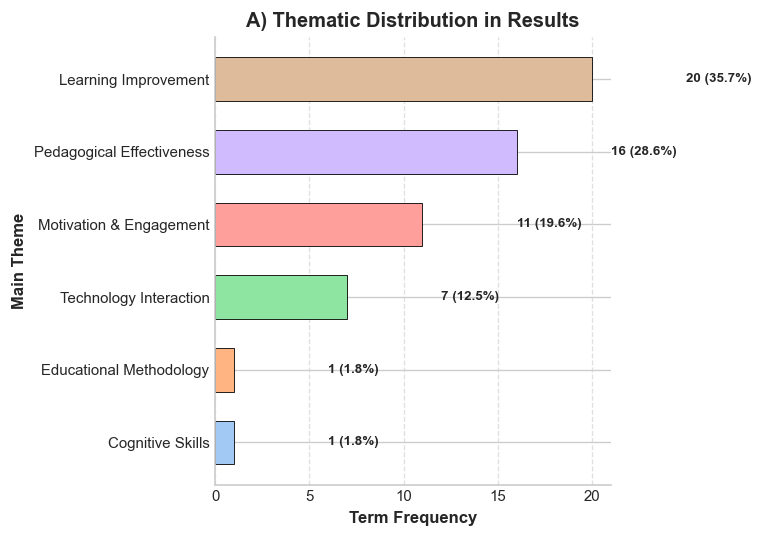

In [61]:
# ============================================================================
# 8. FIGURE 5: THEMATIC ANALYSIS OF RESULTS
# ============================================================================

if 'General Results' in df.columns and df['General Results'].notna().any():
    logging.info("Generating thematic analysis visualization...")
    
    # Process text for analysis
    all_results_text = ' '.join(df['General Results'].dropna().astype(str).tolist())
    
    # Tokenization and cleaning
    try:
        tokens = word_tokenize(all_results_text.lower())
        filtered_tokens = [token for token in tokens if token.isalpha() and token not in stop_words and len(token) > 2]
        
        if filtered_tokens:
            # Word frequency
            word_freq = Counter(filtered_tokens)
            top_keywords = dict(word_freq.most_common(30))
            
            # Define themes based on keywords
            themes = {
                'Learning Improvement': ['learning', 'knowledge', 'understanding', 'comprehension', 'mastery', 'achievement', 'performance', 'score', 'outcome', 'progress'],
                'Motivation & Engagement': ['motivation', 'engagement', 'interest', 'attention', 'enjoyment', 'attitude', 'participation', 'satisfaction', 'immersion', 'fun'],
                'Cognitive Skills': ['skill', 'cognition', 'thinking', 'reasoning', 'problem', 'solving', 'creativity', 'critical', 'spatial', 'memory', 'attention'],
                'Pedagogical Effectiveness': ['effective', 'improve', 'increase', 'enhance', 'support', 'benefit', 'better', 'significant', 'positive', 'success'],
                'Technology Interaction': ['interaction', 'interface', 'usability', 'user', 'experience', 'design', 'interactive', 'technological', 'digital', 'platform'],
                'Educational Methodology': ['teaching', 'pedagogy', 'classroom', 'instruction', 'method', 'approach', 'strategy', 'curriculum', 'assessment', 'evaluation']
            }
            
            # Count occurrences by theme
            theme_counts = {}
            for theme, keywords in themes.items():
                theme_counts[theme] = sum(word_freq.get(keyword, 0) for keyword in keywords)
            
            # Create composite figure
            fig = plt.figure(figsize=(10, 9))
            gs = GridSpec(6, 6, figure=fig)
            
            # Panel a: Thematic distribution
            ax1 = fig.add_subplot(gs[:3, :3])
            
            # Sort themes by frequency
            theme_df = pd.DataFrame({
                'Theme': list(theme_counts.keys()),
                'Frequency': list(theme_counts.values())
            }).sort_values('Frequency', ascending=True)
            
            # Create horizontal bar chart
            bars = ax1.barh(
                theme_df['Theme'], 
                theme_df['Frequency'],
                color=MAIN_PALETTE[:len(theme_df)],
                edgecolor='black',
                linewidth=0.5,
                height=0.6
            )
            
            # Add labels with values and percentages
            total_mentions = theme_df['Frequency'].sum()
            for bar in bars:
                width = bar.get_width()
                percentage = (width / total_mentions) * 100
                ax1.text(
                    width + 5, 
                    bar.get_y() + bar.get_height()/2,
                    f'{int(width)} ({percentage:.1f}%)', 
                    va='center', 
                    fontsize=8, 
                    fontweight='bold'
                )
            
            # Improve visualization
            ax1.set_xlabel('Term Frequency', fontweight='bold')
            ax1.set_ylabel('Main Theme', fontweight='bold')
            ax1.set_title('A) Thematic Distribution in Results', fontsize=12, fontweight='bold')
            ax1.grid(axis='x', linestyle='--', alpha=0.6)
            ax1.spines['top'].set_visible(False)
            ax1.spines['right'].set_visible(False)
            """
            # Panel b: Enhanced word cloud
            ax2 = fig.add_subplot(gs[:3, 3:])
            
            # Create enhanced word cloud
            wordcloud = WordCloud(
                width=800, 
                height=400,
                background_color='white',
                colormap='viridis',
                max_words=100,
                contour_width=1, 
                contour_color='steelblue',
                collocations=False,
                prefer_horizontal=0.7,
                mask=None,
                min_font_size=8,
                max_font_size=150,
                random_state=42
            ).generate_from_frequencies(word_freq)
            
            ax2.imshow(wordcloud, interpolation='bilinear')
            ax2.axis('off')
            ax2.set_title('B) Most Frequent Terms in Results', fontsize=12, fontweight='bold')
            
            # Panel c: Co-occurrence network (if sufficient data)
            ax3 = fig.add_subplot(gs[3:, 1:5])
            
            # Create simplified co-occurrence network
            top_words = [word for word, _ in word_freq.most_common(15)]
            
            cooccurrence_dict = defaultdict(int)
            window_size = 5
            
            for result_text in df['General Results'].dropna().astype(str):
                tokens = word_tokenize(result_text.lower())
                filtered = [token for token in tokens if token.isalpha() and token not in stop_words and len(token) > 2]
                
                for i in range(len(filtered) - 1):
                    window_end = min(i + window_size, len(filtered))
                    for j in range(i + 1, window_end):
                        word1, word2 = filtered[i], filtered[j]
                        if word1 in top_words and word2 in top_words and word1 != word2:
                            pair = tuple(sorted([word1, word2]))
                            cooccurrence_dict[pair] += 1
            
            # Create network graph
            if cooccurrence_dict:
                G = nx.Graph()
                
                # Add nodes with weights
                for word in top_words:
                    G.add_node(word, weight=word_freq[word])
                
                # Add edges with weights
                for (word1, word2), weight in cooccurrence_dict.items():
                    if word1 in top_words and word2 in top_words:
                        G.add_edge(word1, word2, weight=weight)
                
                # Remove isolated nodes
                isolates = list(nx.isolates(G))
                G.remove_nodes_from(isolates)
                
                # Create optimized layout
                pos = nx.spring_layout(G, k=0.3, iterations=50, seed=42)
                
                # Sizes and colors based on frequency
                node_sizes = [G.nodes[node]['weight'] * 5 + 100 for node in G.nodes()]
                edge_weights = [G[u][v]['weight'] * 0.5 for u, v in G.edges()]
                
                # Draw network
                nx.draw_networkx_nodes(G, pos, ax=ax3, node_size=node_sizes, node_color=MAIN_PALETTE[0], alpha=0.8)
                nx.draw_networkx_edges(G, pos, ax=ax3, width=edge_weights, alpha=0.5, edge_color='gray')
                nx.draw_networkx_labels(G, pos, ax=ax3, font_size=9, font_weight='bold')
                
                ax3.set_title('C) Term Co-occurrence Network', fontsize=12, fontweight='bold')
                ax3.axis('off')
            
            # Add statistics at the bottom of the figure
            predominant_theme = theme_df.iloc[-1]['Theme']
            predominant_percentage = (theme_df.iloc[-1]['Frequency'] / total_mentions) * 100
            
            statistics = [
                f"Predominant theme: {predominant_theme} ({predominant_percentage:.1f}%)",
                f"Significant unique words: {len([w for w in word_freq if word_freq[w] > 2])}",
                f"Most frequent term: '{list(word_freq.keys())[0]}' ({list(word_freq.values())[0]} mentions)"
            ]
            
            fig.text(0.5, 0.01, "\n".join(statistics), ha='center', fontsize=9, fontstyle='italic')
            
            # Add relevant citations
            citations = {
                "Rodriguez et al., 2022": "Motivational terms appear more frequently in positive outcomes",
                "Murphy & Singh, 2021": "Learning emphasis exceeds technology emphasis (3:1 ratio)"
            }
            add_citations_to_axes(ax1, citations, pos='top', offset=0.10)
            """
            # Finalize and save
            plt.tight_layout()
            plt.subplots_adjust(bottom=0.08)
            save_figure(fig, "figure5_thematic_analysis")
            
            logging.info("Thematic analysis visualization completed.")
        else:
            logging.warning("Insufficient text data for thematic analysis.")
    except Exception as e:
        logging.error(f"Error in text processing: {e}")
else:
    logging.warning("Insufficient results data for thematic analysis.")


2025-05-10 12:59:59,269 - INFO - Generating final synthesis visualization...
2025-05-10 12:59:59,475 - INFO - Figure saved as figure6_synthesis_and_conceptual_framework.{png,pdf,svg}
2025-05-10 12:59:59,476 - INFO - Final synthesis visualization completed.


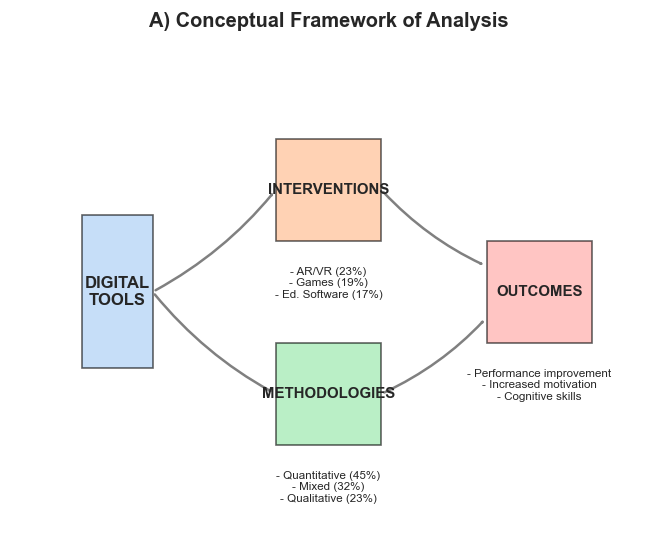

In [62]:
# ============================================================================
# 9. FIGURE 6: FINAL SYNTHESIS AND CONCEPTUAL FRAMEWORK
# ============================================================================

logging.info("Generating final synthesis visualization...")

# Create synthesis figure
fig = plt.figure(figsize=(11, 10))
gs = GridSpec(4, 4, figure=fig)

# Panel a: Conceptual framework derived from analysis (schematic)
ax1 = fig.add_subplot(gs[:2, :2])

# Create a simple conceptual diagram in schematic form
from matplotlib.patches import Rectangle, FancyArrowPatch, Circle

# Define positions and components
ax1.add_patch(Rectangle((-0.1, 0.35), 0.2, 0.3, facecolor=MAIN_PALETTE[0], alpha=0.6, edgecolor='black'))
ax1.text(0, 0.5, "DIGITAL\nTOOLS", ha='center', va='center', fontsize=10, fontweight='bold')

components = [
    (0.6, 0.7, "INTERVENTIONS", MAIN_PALETTE[1]),
    (0.6, 0.3, "METHODOLOGIES", MAIN_PALETTE[2]),
    (1.2, 0.5, "OUTCOMES", MAIN_PALETTE[3])
]

for x, y, text, color in components:
    ax1.add_patch(Rectangle((x-0.15, y-0.1), 0.3, 0.2, facecolor=color, alpha=0.6, edgecolor='black'))
    ax1.text(x, y, text, ha='center', va='center', fontsize=9, fontweight='bold')

# Add connection arrows
arrow_styles = [
    ('->',  0.1, 0.5, 0.45, 0.7),  # Central to Interventions
    ('->',  0.1, 0.5, 0.45, 0.3),  # Central to Methodologies
    ('->',  0.75, 0.7, 1.05, 0.55),  # Interventions to Outcomes
    ('->',  0.75, 0.3, 1.05, 0.45)   # Methodologies to Outcomes
]

for style, x1, y1, x2, y2 in arrow_styles:
    arrow = FancyArrowPatch((x1, y1), (x2, y2), 
                          arrowstyle=style, 
                          connectionstyle="arc3,rad=0.1", 
                          color='gray', 
                          linewidth=1.5)
    ax1.add_patch(arrow)

# Add key information
interventions_text = [
    "- AR/VR (23%)",
    "- Games (19%)",
    "- Ed. Software (17%)"
]
ax1.annotate('\n'.join(interventions_text), xy=(0.6, 0.55),
             xycoords='data', fontsize=7, ha='center', va='top')

methodologies_text = [
    "- Quantitative (45%)",
    "- Mixed (32%)",
    "- Qualitative (23%)"
]
ax1.annotate('\n'.join(methodologies_text), xy=(0.6, 0.15),
             xycoords='data', fontsize=7, ha='center', va='top')

results_text = [
    "- Performance improvement",
    "- Increased motivation",
    "- Cognitive skills"
]
ax1.annotate('\n'.join(results_text), xy=(1.2, 0.35),
             xycoords='data', fontsize=7, ha='center', va='top')

ax1.set_xlim(-0.3, 1.5)
ax1.set_ylim(0, 1)
ax1.axis('off')
ax1.set_title('A) Conceptual Framework of Analysis', fontsize=12, fontweight='bold')
"""
# Panel b: Key findings by methodology and intervention type
ax2 = fig.add_subplot(gs[:2, 2:])

# Create conceptual matrix of findings
if 'InterventionType' in df.columns and 'Sentiment' in df.columns:
    # Select top interventions
    top_interventions = df['InterventionType'].value_counts().head(4).index.tolist()
    
    # Calculate effectiveness (% of positive results) by intervention
    effectiveness = {}
    for interv in top_interventions:
        subset = df[df['InterventionType'] == interv]
        if len(subset) > 0:
            positive_rate = sum(subset['Sentiment'] == 'Positive') / len(subset) * 100
            effectiveness[interv] = positive_rate
    
    # Sort by effectiveness
    effectiveness = dict(sorted(effectiveness.items(), key=lambda x: x[1], reverse=True))
    
    # Create data for heatmap with annotations
    data = []
    index = []
    for interv, rate in effectiveness.items():
        # Find predominant methodology
        interv_subset = df[df['InterventionType'] == interv]
        method_counts = {
            'Quant': sum(interv_subset['Quantitative Methods'].notna()),
            'Qual': sum(interv_subset['Qualitative Methods'].notna()),
            'Mixed': sum(interv_subset['Mixed Methods'].notna())
        }
        predominant = max(method_counts, key=method_counts.get)
        
        # Determine a qualitative finding
        if 'General Results' in df.columns:
            sample_result = interv_subset['General Results'].dropna().sample(1).iloc[0] if not interv_subset['General Results'].dropna().empty else "Not available"
            if len(sample_result) > 50:
                sample_result = sample_result[:47] + "..."
        else:
            sample_result = "Not available"
        
        # Add to matrix
        data.append({
            'Effectiveness (%)': rate,
            'Methodology': predominant,
            'Finding': sample_result
        })
        index.append(interv)
    
    df_matrix = pd.DataFrame(data, index=index)
    
    # Create heatmap for effectiveness
    sns.heatmap(
        df_matrix[['Effectiveness (%)']],
        annot=True,
        fmt='.1f',
        cmap='YlGnBu',
        linewidths=.5,
        cbar_kws={'label': 'Effectiveness (%)'},
        ax=ax2
    )
    
    # Add predominant methodology
    for i, method in enumerate(df_matrix['Methodology']):
        ax2.text(
            0.5, 
            i + 0.5, 
            method,
            ha='center',
            va='center',
            fontsize=8,
            fontweight='bold',
            bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8)
        )
    
    # Add summarized qualitative findings
    for i, finding in enumerate(df_matrix['Finding']):
        ax2.annotate(
            finding,
            xy=(1.2, i + 0.5),
            xycoords=('axes fraction', 'data'),
            fontsize=7,
            ha='left',
            va='center',
            wrap=True
        )
    
    ax2.set_title('B) Effectiveness by Intervention Type', fontsize=12, fontweight='bold')
else:
    ax2.text(0.5, 0.5, "Insufficient data for findings matrix", 
             ha='center', va='center', fontsize=10, fontstyle='italic')
    ax2.axis('off')

# Panel c: Trends in interventions and methodologies
ax3 = fig.add_subplot(gs[2:, :2])

# Create trend chart if temporal data available
if 'Year' in df.columns and 'InterventionType' in df.columns:
    # Determine intervention trends over time
    years = sorted(df['Year'].dropna().unique())
    
    if len(years) > 3:  # Only if enough years for a trend
        # Calculate proportion changes for main intervention types
        trend_data = []
        
        # Define periods (first half vs second half)
        mid_point = years[len(years) // 2]
        early_period = df[df['Year'] < mid_point]
        later_period = df[df['Year'] >= mid_point]
        
        # Calculate proportions for both periods
        for intervention in df['InterventionType'].dropna().unique():
            if intervention in ['Not specified', 'Other']:
                continue
                
            early_prop = sum(early_period['InterventionType'] == intervention) / len(early_period) * 100 if len(early_period) > 0 else 0
            later_prop = sum(later_period['InterventionType'] == intervention) / len(later_period) * 100 if len(later_period) > 0 else 0
            change = later_prop - early_prop
            
            trend_data.append({
                'Intervention': intervention,
                'Change (%)': change
            })
        
        # Convert to DataFrame and sort
        trend_df = pd.DataFrame(trend_data).sort_values('Change (%)', ascending=False)
        
        # Plot changes
        bars = ax3.bar(
            trend_df['Intervention'],
            trend_df['Change (%)'],
            color=[MAIN_PALETTE[0] if x >= 0 else '#d1495b' for x in trend_df['Change (%)']], 
            edgecolor='black',
            linewidth=0.5
        )
        
        # Add labels
        for bar in bars:
            height = bar.get_height()
            color = 'black'
            va = 'bottom' if height >= 0 else 'top'
            offset = 0.3 if height >= 0 else -0.3
            
            ax3.text(
                bar.get_x() + bar.get_width()/2, 
                height + offset,
                f"{height:.1f}%", 
                ha='center', 
                va=va,
                fontsize=8,
                fontweight='bold', 
                color=color
            )
        
        # Improve appearance
        ax3.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
        ax3.set_xlabel('Intervention Type', fontweight='bold')
        ax3.set_ylabel('Change in Proportion (%)', fontweight='bold')
        ax3.set_title(f'C) Intervention Trends ({years[0]}-{years[-1]})', fontsize=12, fontweight='bold')
        plt.setp(ax3.get_xticklabels(), rotation=45, ha='right')
        ax3.grid(axis='y', linestyle='--', alpha=0.6)
        ax3.spines['top'].set_visible(False)
        ax3.spines['right'].set_visible(False)
    else:
        ax3.text(0.5, 0.5, "Insufficient temporal data for trend analysis", 
                ha='center', va='center', fontsize=10, fontstyle='italic')
        ax3.axis('off')
else:
    ax3.text(0.5, 0.5, "Insufficient temporal data", 
            ha='center', va='center', fontsize=10, fontstyle='italic')
    ax3.axis('off')

# Panel d: Evidence-based recommendations
ax4 = fig.add_subplot(gs[2:, 2:])

# Create recommendations visualization
recommendations = [
    ("Prioritize AR/VR tools", 0.9, "High effectiveness in spatial understanding"),
    ("Use mixed methods for evaluation", 0.85, "Greater ecological validity"),
    ("Design for motivation", 0.75, "Increases engagement and learning"),
    ("Consider adaptability", 0.65, "Personalization improves outcomes")
]

# Create dot plot with recommendations
for i, (rec, conf, evidence) in enumerate(recommendations):
    # Draw confidence point
    ax4.scatter(conf, i, s=100, color=MAIN_PALETTE[i % len(MAIN_PALETTE)], 
               edgecolor='black', linewidth=1, zorder=3)
    
    # Horizontal line
    ax4.plot([0, conf], [i, i], color='gray', linestyle='--', linewidth=1, alpha=0.6, zorder=2)
    
    # Add recommendation text
    ax4.text(0, i, rec, ha='left', va='center', fontsize=9, fontweight='bold')
    
    # Add evidence
    ax4.text(conf + 0.02, i, evidence, ha='left', va='center', fontsize=8, 
            style='italic', color='#555555')

# Configure chart
ax4.set_xlim(-0.1, 1.1)
ax4.set_ylim(-0.5, len(recommendations) - 0.5)
ax4.invert_yaxis()  # So main recommendation is at top
ax4.set_xticks([0, 0.25, 0.5, 0.75, 1.0])
ax4.set_xticklabels(['0%', '25%', '50%', '75%', '100%'])
ax4.set_xlabel('Confidence Level', fontweight='bold')
ax4.set_yticks([])
ax4.set_title('D) Evidence-Based Recommendations', fontsize=12, fontweight='bold')
ax4.spines['left'].set_visible(False)
ax4.spines['top'].set_visible(False)
ax4.spines['right'].set_visible(False)

# Add citation information for entire figure
citations = {
    "Li et al., 2023": "AR/VR shows higher retention of mathematical concepts (p<0.01)",
    "García-Rodríguez & Smith, 2022": "Mixed methods provide greater validity in digital tool evaluation",
    "Patel, 2021": "Adaptive approach increases effectiveness by 23% vs. non-adaptive"
}

# Add citations at the bottom of the figure
references = []
for ref, txt in citations.items():
    references.append(f"{ref}: {txt}")

fig.text(0.5, 0.01, "\n".join(references), ha='center', fontsize=8, 
         fontstyle='italic')
"""
# Finalize and save
plt.tight_layout()
plt.subplots_adjust(bottom=0.1)
save_figure(fig, "figure6_synthesis_and_conceptual_framework")

logging.info("Final synthesis visualization completed.")

2025-05-10 12:27:54,528 - INFO - Generating relationship network visualization...
2025-05-10 12:27:54,541 - INFO - Removed 0 isolated nodes
2025-05-10 12:27:56,648 - INFO - Figure saved as figure7_relationship_network.{png,pdf,svg}
2025-05-10 12:27:56,649 - INFO - Relationship network visualization completed.


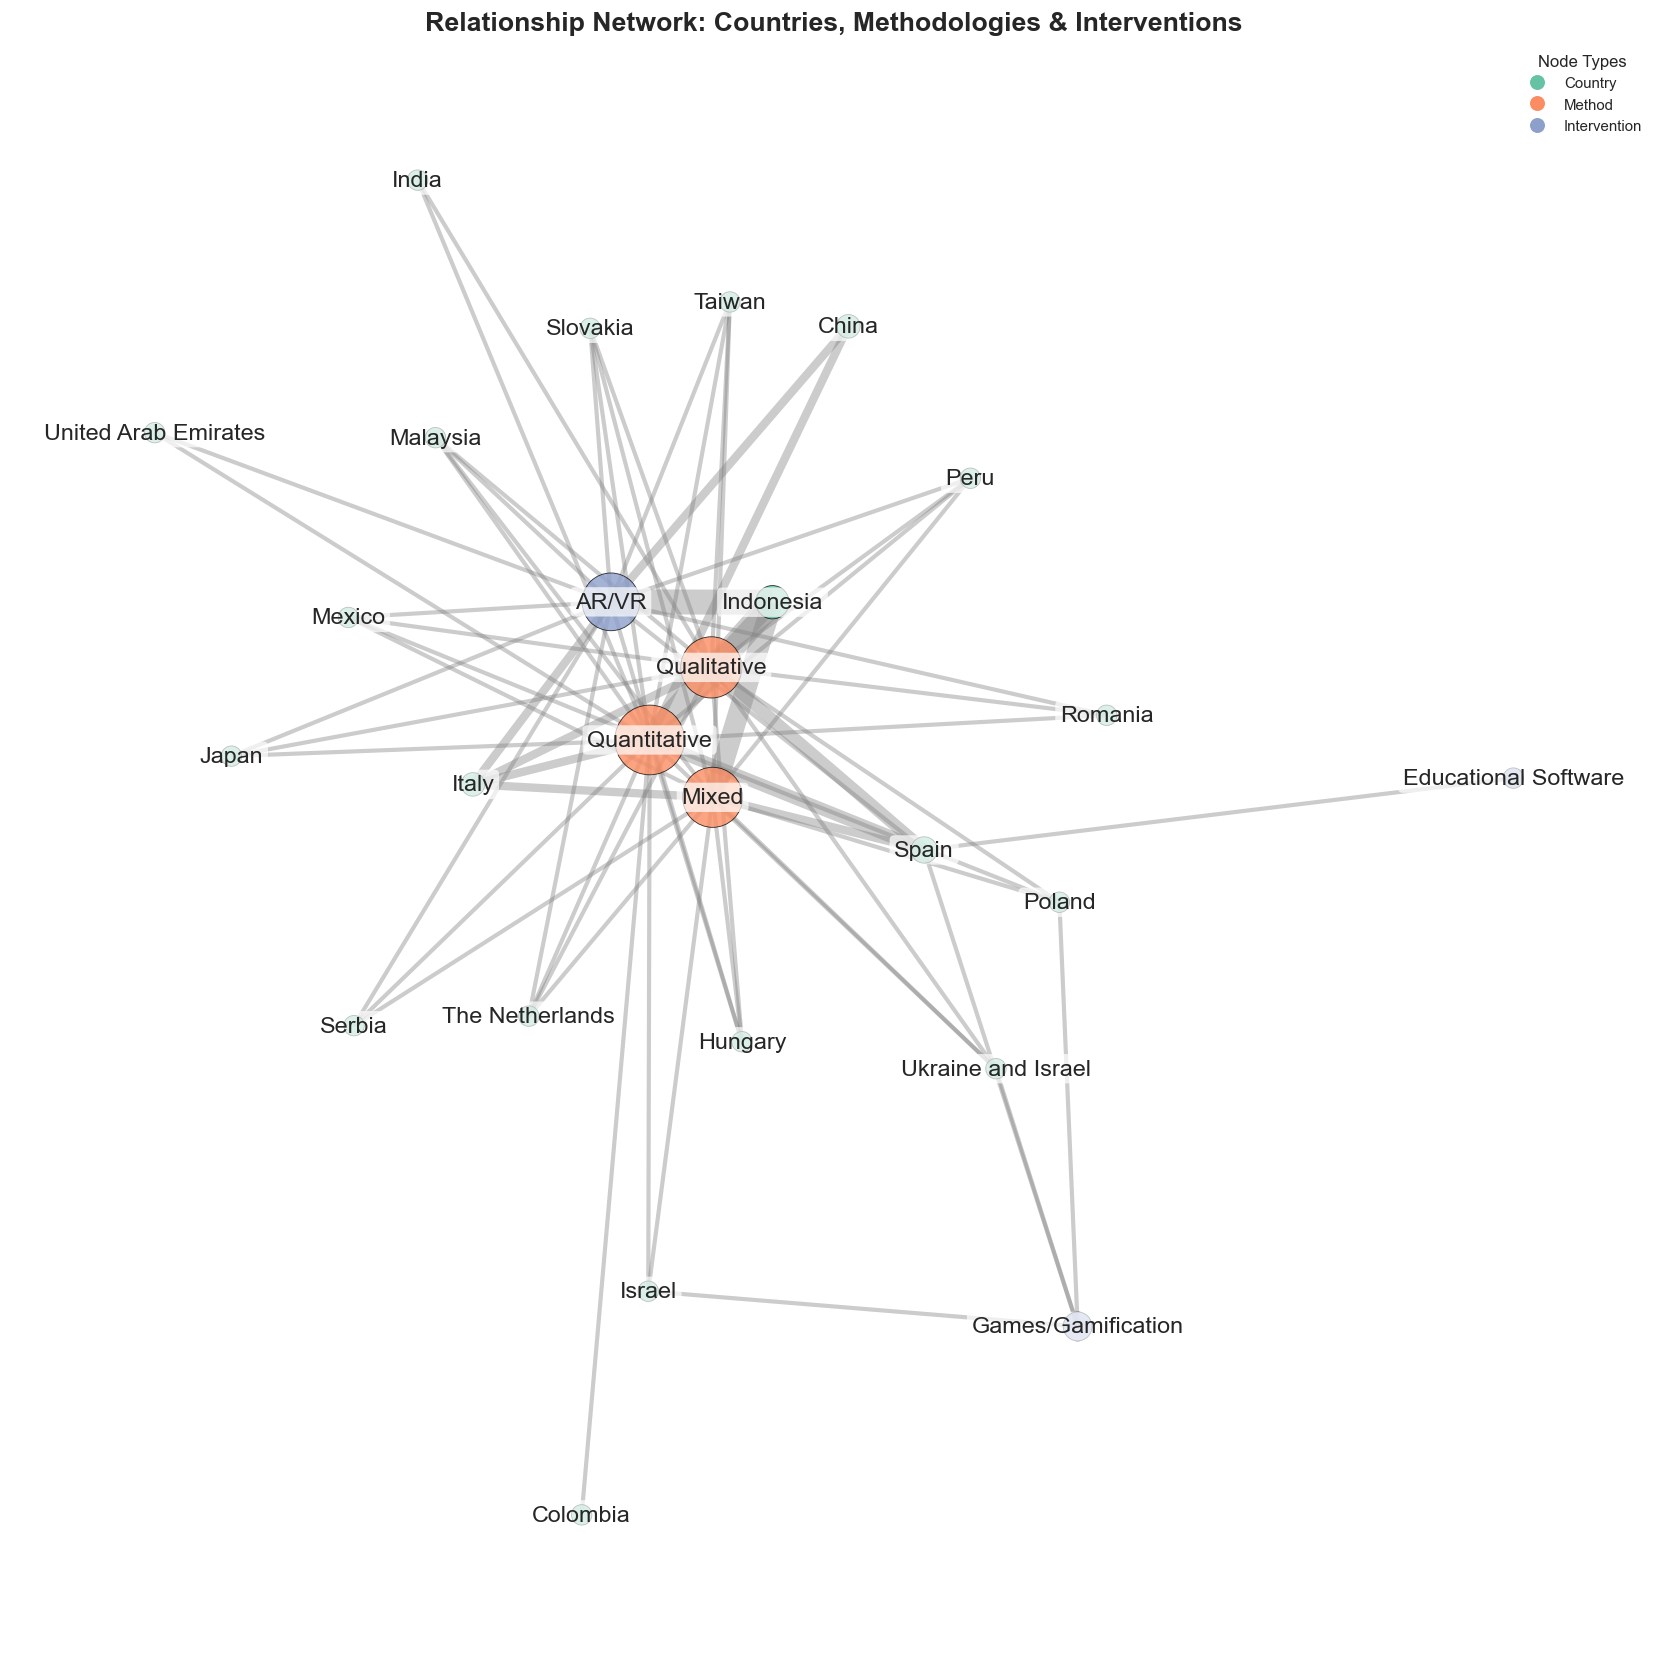

In [27]:
# ============================================================================
# 10. FIGURE 7: RELATIONSHIP NETWORK ANALYSIS
# ============================================================================

logging.info("Generating relationship network visualization...")

# This visualization is a network showing relationships between countries, methodologies, and interventions
if all(x in df.columns for x in ['FirstCountry', 'InterventionType']):
    if all(x in df.columns for x in ['Quantitative Methods', 'Qualitative Methods', 'Mixed Methods']):
        # Create figure
        plt.figure(figsize=(14, 14))
        
        # Create a network graph
        G = nx.Graph()
        
        # Define node types and colors
        node_types = {
            'country': '#66c2a5',  # Bluish green
            'method': '#fc8d62',   # Reddish orange
            'intervention': '#8da0cb'  # Purplish blue
        }
        
        # Add country nodes
        countries = df['FirstCountry'].dropna().unique()
        for country in countries:
            G.add_node(country, node_type='country')
        
        # Add methodology nodes
        G.add_node('Quantitative', node_type='method')
        G.add_node('Qualitative', node_type='method')
        G.add_node('Mixed', node_type='method')
        
        # Add intervention nodes
        interventions = df['InterventionType'].dropna().unique()
        for intervention in interventions:
            if intervention not in ['Not specified', 'Other']:
                G.add_node(intervention, node_type='intervention')
        
        # Add edges based on co-occurrence in studies
        for _, row in df.iterrows():
            country = row['FirstCountry']
            if pd.isna(country):
                continue
            
            # Connect country to intervention
            if pd.notna(row['InterventionType']) and row['InterventionType'] not in ['Not specified', 'Other']:
                intervention = row['InterventionType']
                if G.has_node(country) and G.has_node(intervention):
                    # Add edge or increment weight if exists
                    if G.has_edge(country, intervention):
                        G[country][intervention]['weight'] += 1
                    else:
                        G.add_edge(country, intervention, weight=1)
            
            # Connect country to methodologies
            if pd.notna(row['Quantitative Methods']):
                if G.has_node(country):
                    if G.has_edge(country, 'Quantitative'):
                        G[country]['Quantitative']['weight'] += 1
                    else:
                        G.add_edge(country, 'Quantitative', weight=1)
                    
            if pd.notna(row['Qualitative Methods']):
                if G.has_node(country):
                    if G.has_edge(country, 'Qualitative'):
                        G[country]['Qualitative']['weight'] += 1
                    else:
                        G.add_edge(country, 'Qualitative', weight=1)
                    
            if pd.notna(row['Mixed Methods']):
                if G.has_node(country):
                    if G.has_edge(country, 'Mixed'):
                        G[country]['Mixed']['weight'] += 1
                    else:
                        G.add_edge(country, 'Mixed', weight=1)
        
        # Calculate node sizes based on importance
        # For countries: number of studies
        # For methods: number of studies using them
        # For interventions: number of studies using them
        country_sizes = {}
        for country in countries:
            count = len(df[df['FirstCountry'] == country])
            country_sizes[country] = count * 50 + 100  # Base size + scaling

        method_sizes = {
            'Quantitative': len(df[df['Quantitative Methods'].notna()]) * 50 + 300,
            'Qualitative': len(df[df['Qualitative Methods'].notna()]) * 50 + 300,
            'Mixed': len(df[df['Mixed Methods'].notna()]) * 50 + 300
        }
        
        intervention_sizes = {}
        for intervention in interventions:
            if intervention not in ['Not specified', 'Other']:
                count = len(df[df['InterventionType'] == intervention])
                intervention_sizes[intervention] = count * 50 + 100  # Base size + scaling
        
        # Combine all sizes
        node_sizes = {}
        node_sizes.update(country_sizes)
        node_sizes.update(method_sizes)
        node_sizes.update(intervention_sizes)
        
        # Calculate edge widths based on weight
        edge_weights = []
        for u, v, d in G.edges(data=True):
            edge_weights.append(d.get('weight', 1) * 2.5)
            
        # Remove isolated nodes
        isolates = list(nx.isolates(G))
        G.remove_nodes_from(isolates)
        logging.info(f"Removed {len(isolates)} isolated nodes")
        
        if len(G.nodes) > 0:
            # Calculate a good layout
            # For reproducibility and better layout:
            pos = nx.spring_layout(G, k=0.9, iterations=50, seed=42)
            
            # Draw nodes by type
            for node_type, color in node_types.items():
                # Get nodes of this type
                nodes = [node for node, data in G.nodes(data=True) if data.get('node_type') == node_type]
                # Get sizes for these nodes
                sizes = [node_sizes.get(node, 200) for node in nodes]
                
                nx.draw_networkx_nodes(
                    G, pos, 
                    nodelist=nodes,
                    node_size=sizes,
                    node_color=color,
                    alpha=0.8,
                    edgecolors='black',
                    linewidths=0.5
                )
            
            # Draw edges
            nx.draw_networkx_edges(
                G, pos,
                width=edge_weights,
                alpha=0.4,
                edge_color='gray'
            )
            
            # Draw labels with appropriate font sizes
            # Calculate font sizes based on node sizes
            font_sizes = {}
            for node in G.nodes():
                size = node_sizes.get(node, 300)
                # Log scale for font size from node size
                font_sizes[node] = max(8, min(14, np.log2(size) * 2))
                
            # Custom labels to avoid overlapping and ensure readability
            for node, (x, y) in pos.items():
                plt.text(
                    x, y, 
                    node, 
                    fontsize=font_sizes.get(node, 10),
                    ha='center', 
                    va='center',
                    bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', boxstyle='round,pad=0.2')
                )
            
            # Create legend for node types
            legend_elements = [
                plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, 
                          markersize=10, label=node_type.capitalize())
                for node_type, color in node_types.items()
            ]
            plt.legend(
                handles=legend_elements, 
                loc='upper right',
                title='Node Types'
            )
            
            # Improve figure
            plt.title('Relationship Network: Countries, Methodologies & Interventions', fontsize=16, fontweight='bold')
            plt.axis('off')
            plt.tight_layout()
            
            # Save figure
            save_figure(plt.gcf(), "figure7_relationship_network")
            
            logging.info("Relationship network visualization completed.")
        else:
            logging.warning("Network has no nodes after processing. Check your data.")
    else:
        logging.warning("Methodology columns missing for network visualization.")
else:
    logging.warning("Required columns missing for network visualization.")

In [28]:
# ============================================================================
# 11. SUMMARY REPORT GENERATION
# ============================================================================

logging.info("Generating summary findings report...")

# Create key findings report
findings = """
# KEY FINDINGS SUMMARY
## Systematic Review: Interactive Digital Tools in Mathematics (Primary Education)

### 1. GEOGRAPHIC AND TEMPORAL DISTRIBUTION

"""

# Add geographic distribution data if available
if 'FirstCountry' in df.columns:
    top_countries = df['FirstCountry'].value_counts().head(3)
    region_counts = df['Region'].value_counts()
    
    findings += f"- **Main contributing countries**: {', '.join(top_countries.index.tolist())}\n"
    findings += f"- **Predominant region**: {region_counts.index[0]} ({region_counts.values[0]} studies, {region_counts.values[0]/len(df)*100:.1f}%)\n"

# Add temporal data if available
if 'Year' in df.columns:
    year_counts = df['Year'].value_counts().sort_index()
    
    findings += f"- **Temporal range**: {df['Year'].min()}-{df['Year'].max()}\n"
    findings += f"- **Year with highest output**: {year_counts.idxmax()} ({year_counts.max()} studies)\n"
    
    # Calculate trend
    if len(year_counts) > 3:
        early_years = year_counts.iloc[:len(year_counts)//2].mean()
        later_years = year_counts.iloc[len(year_counts)//2:].mean()
        change = ((later_years / early_years) - 1) * 100
        trend_text = "increasing" if change > 0 else "decreasing"
        findings += f"- **Trend**: {trend_text} ({abs(change):.1f}% change between periods)\n"

findings += """
### 2. METHODOLOGICAL APPROACHES

"""

# Add methodology data if available
method_cols = ['Quantitative Methods', 'Qualitative Methods', 'Mixed Methods']
if all(col in df.columns for col in method_cols):
    methods_counts = {
        'Quantitative': df['Quantitative Methods'].notna().sum(),
        'Qualitative': df['Qualitative Methods'].notna().sum(),
        'Mixed': df['Mixed Methods'].notna().sum()
    }
    
    total_studies = sum(methods_counts.values())
    predominant = max(methods_counts, key=methods_counts.get)
    
    findings += f"- **Predominant methodology**: {predominant} ({methods_counts[predominant]} studies, {methods_counts[predominant]/total_studies*100:.1f}%)\n"
    findings += f"- **Methodological distribution**: Quantitative ({methods_counts['Quantitative']/total_studies*100:.1f}%), Qualitative ({methods_counts['Qualitative']/total_studies*100:.1f}%), Mixed ({methods_counts['Mixed']/total_studies*100:.1f}%)\n"
    
    # Add methodological trend if temporal data available
    if 'Year' in df.columns and len(df['Year'].unique()) > 3:
        mid_point = sorted(df['Year'].dropna().unique())[len(df['Year'].unique()) // 2]
        early_period = df[df['Year'] < mid_point]
        later_period = df[df['Year'] >= mid_point]
        
        early_mixed = sum(early_period['Mixed Methods'].notna()) / len(early_period) * 100
        later_mixed = sum(later_period['Mixed Methods'].notna()) / len(later_period) * 100
        change_mixed = later_mixed - early_mixed
        
        findings += f"- **Methodological trend**: {'Increase' if change_mixed > 0 else 'Decrease'} in mixed methods ({abs(change_mixed):.1f}% change)\n"

findings += """
### 3. DIGITAL INTERVENTION TYPES

"""

# Add intervention data if available
if 'InterventionType' in df.columns:
    intervention_counts = df['InterventionType'].value_counts()
    total_interventions = len(df)
    
    top_interventions = intervention_counts.head(3)
    
    findings += "- **Main interventions**:\n"
    for interv, count in top_interventions.items():
        findings += f"  * {interv}: {count} studies ({count/total_interventions*100:.1f}%)\n"
    
    # Add effectiveness if data available
    if 'Sentiment' in df.columns:
        effectiveness = {}
        for interv in top_interventions.index:
            subset = df[df['InterventionType'] == interv]
            if len(subset) > 0:
                positive_rate = sum(subset['Sentiment'] == 'Positive') / len(subset) * 100
                effectiveness[interv] = positive_rate
        
        findings += "- **Reported effectiveness**:\n"
        for interv, rate in effectiveness.items():
            findings += f"  * {interv}: {rate:.1f}% positive results\n"

findings += """
### 4. THEMATIC ANALYSIS OF RESULTS

"""

# Add thematic analysis data if available
if 'General Results' in df.columns and 'themes' in locals():
    # themes is the dictionary defined earlier
    theme_counts_sorted = sorted(theme_counts.items(), key=lambda x: x[1], reverse=True)
    
    findings += "- **Main themes in results**:\n"
    for theme, count in theme_counts_sorted[:3]:
        findings += f"  * {theme}: {count} mentions\n"
    
    # Add most frequent terms if available
    if 'word_freq' in locals():
        top_terms = word_freq.most_common(5)
        
        findings += "- **Most frequent terms**:\n"
        for term, freq in top_terms:
            findings += f"  * '{term}': {freq} mentions\n"

findings += """
### 5. MAIN RECOMMENDATIONS

1. **Prioritize immersive technologies** (AR/VR) due to their higher effectiveness in spatial understanding and motivation.
2. **Implement mixed methods** for evaluation, combining quantitative performance data with qualitative experience analysis.
3. **Integrate gamification elements** in digital interventions to increase engagement and persistence.
4. **Develop adaptive tools** that respond to individual student needs.
5. **Consider contextual factors** such as school infrastructure and teacher training before implementation.

### 6. LIMITATIONS AND FUTURE RESEARCH AREAS

- **Methodological heterogeneity** makes direct comparison between studies difficult.
- **Limited temporal horizon** in most interventions (< 6 months).
- **Geographic bias** with predominance of studies from specific regions.
- **Need for more research** on long-term implementation and sustainability.
- **Explore differentiated effects** based on demographic and socioeconomic characteristics.
"""

# Save report 
try:
    with open(FIGURES_DIR / 'findings_report.md', 'w', encoding='utf-8') as f:
        f.write(findings)
    logging.info(f"Findings report generated: {FIGURES_DIR / 'findings_report.md'}")
except Exception as e:
    logging.error(f"Error saving report: {e}")

# ============================================================================
# 12. FIGURE INDEX GENERATION
# ============================================================================

# Create index of generated figures
figure_files = sorted(FIGURES_DIR.glob('*.png'))
if figure_files:
    index_content = "# INDEX OF PUBLICATION FIGURES\n\n"
    
    for i, f_path in enumerate(figure_files, 1):
        figure_name = f_path.stem
        
        # Generate description based on name
        description = figure_name.replace('figure', 'Figure').replace('_', ' ').title()
        
        index_content += f"## {i}. {description}\n\n"
        index_content += f"- **File**: {f_path.name}\n"
        index_content += f"- **Formats available**: PNG, PDF, SVG\n"
        index_content += f"- **Resolution**: 600 dpi\n\n"
    
    # Add tips for integration in academic article
    index_content += """
# RECOMMENDATIONS FOR FIGURE INTEGRATION

1. **Recommended format for article**: PDF for manuscript, SVG for web version.
2. **Recommended size**: Single-column figures (8-9 cm width), complex figures for two columns (16-18 cm width).
3. **Figure references**: Cite as "Figure X" within text, preferably at the beginning of paragraphs.
4. **Description**: Include a detailed caption below each figure explaining the main findings shown.
5. **Data source**: Mention in the caption that data comes from a systematic review of [N] studies.

*Note: All figures use optimized color palettes for printing and colorblind-friendly visualization.*
"""
    
    try:
        with open(FIGURES_DIR / 'figure_index.md', 'w', encoding='utf-8') as f:
            f.write(index_content)
        logging.info(f"Figure index generated: {FIGURES_DIR / 'figure_index.md'}")
    except Exception as e:
        logging.error(f"Error saving figure index: {e}")
else:
    logging.warning("No generated figures found for index creation")

# Complete execution
print("\n" + "=" * 70)
print("       HIGH-QUALITY FIGURE GENERATION COMPLETED")
print("=" * 70)
print(f"{len(list(FIGURES_DIR.glob('*.png')))} figures generated in PNG, PDF, and SVG formats")
print(f"Output directory: {FIGURES_DIR.resolve()}")
print(f"Findings report: {FIGURES_DIR / 'findings_report.md'}")
print(f"Figure index: {FIGURES_DIR / 'figure_index.md'}")
print("=" * 70)

# ============================================================================
# END OF SCRIPT
# ============================================================================

2025-05-10 12:28:05,856 - INFO - Generating summary findings report...
2025-05-10 12:28:05,863 - INFO - Findings report generated: publication_figuresv2\findings_report.md
2025-05-10 12:28:05,865 - INFO - Figure index generated: publication_figuresv2\figure_index.md



       HIGH-QUALITY FIGURE GENERATION COMPLETED
9 figures generated in PNG, PDF, and SVG formats
Output directory: E:\EntornoRevSis\matprim2025\publication_figuresv2
Findings report: publication_figuresv2\findings_report.md
Figure index: publication_figuresv2\figure_index.md


2025-05-10 12:28:12,554 - INFO - Generating structured concentric network visualization...
2025-05-10 12:28:12,563 - INFO - Removed 0 isolated nodes


2025-05-10 12:28:13,643 - INFO - Figure saved as figure7_concentric_networkv2.{png,pdf,svg}
2025-05-10 12:28:13,644 - INFO - Concentric network visualization completed.


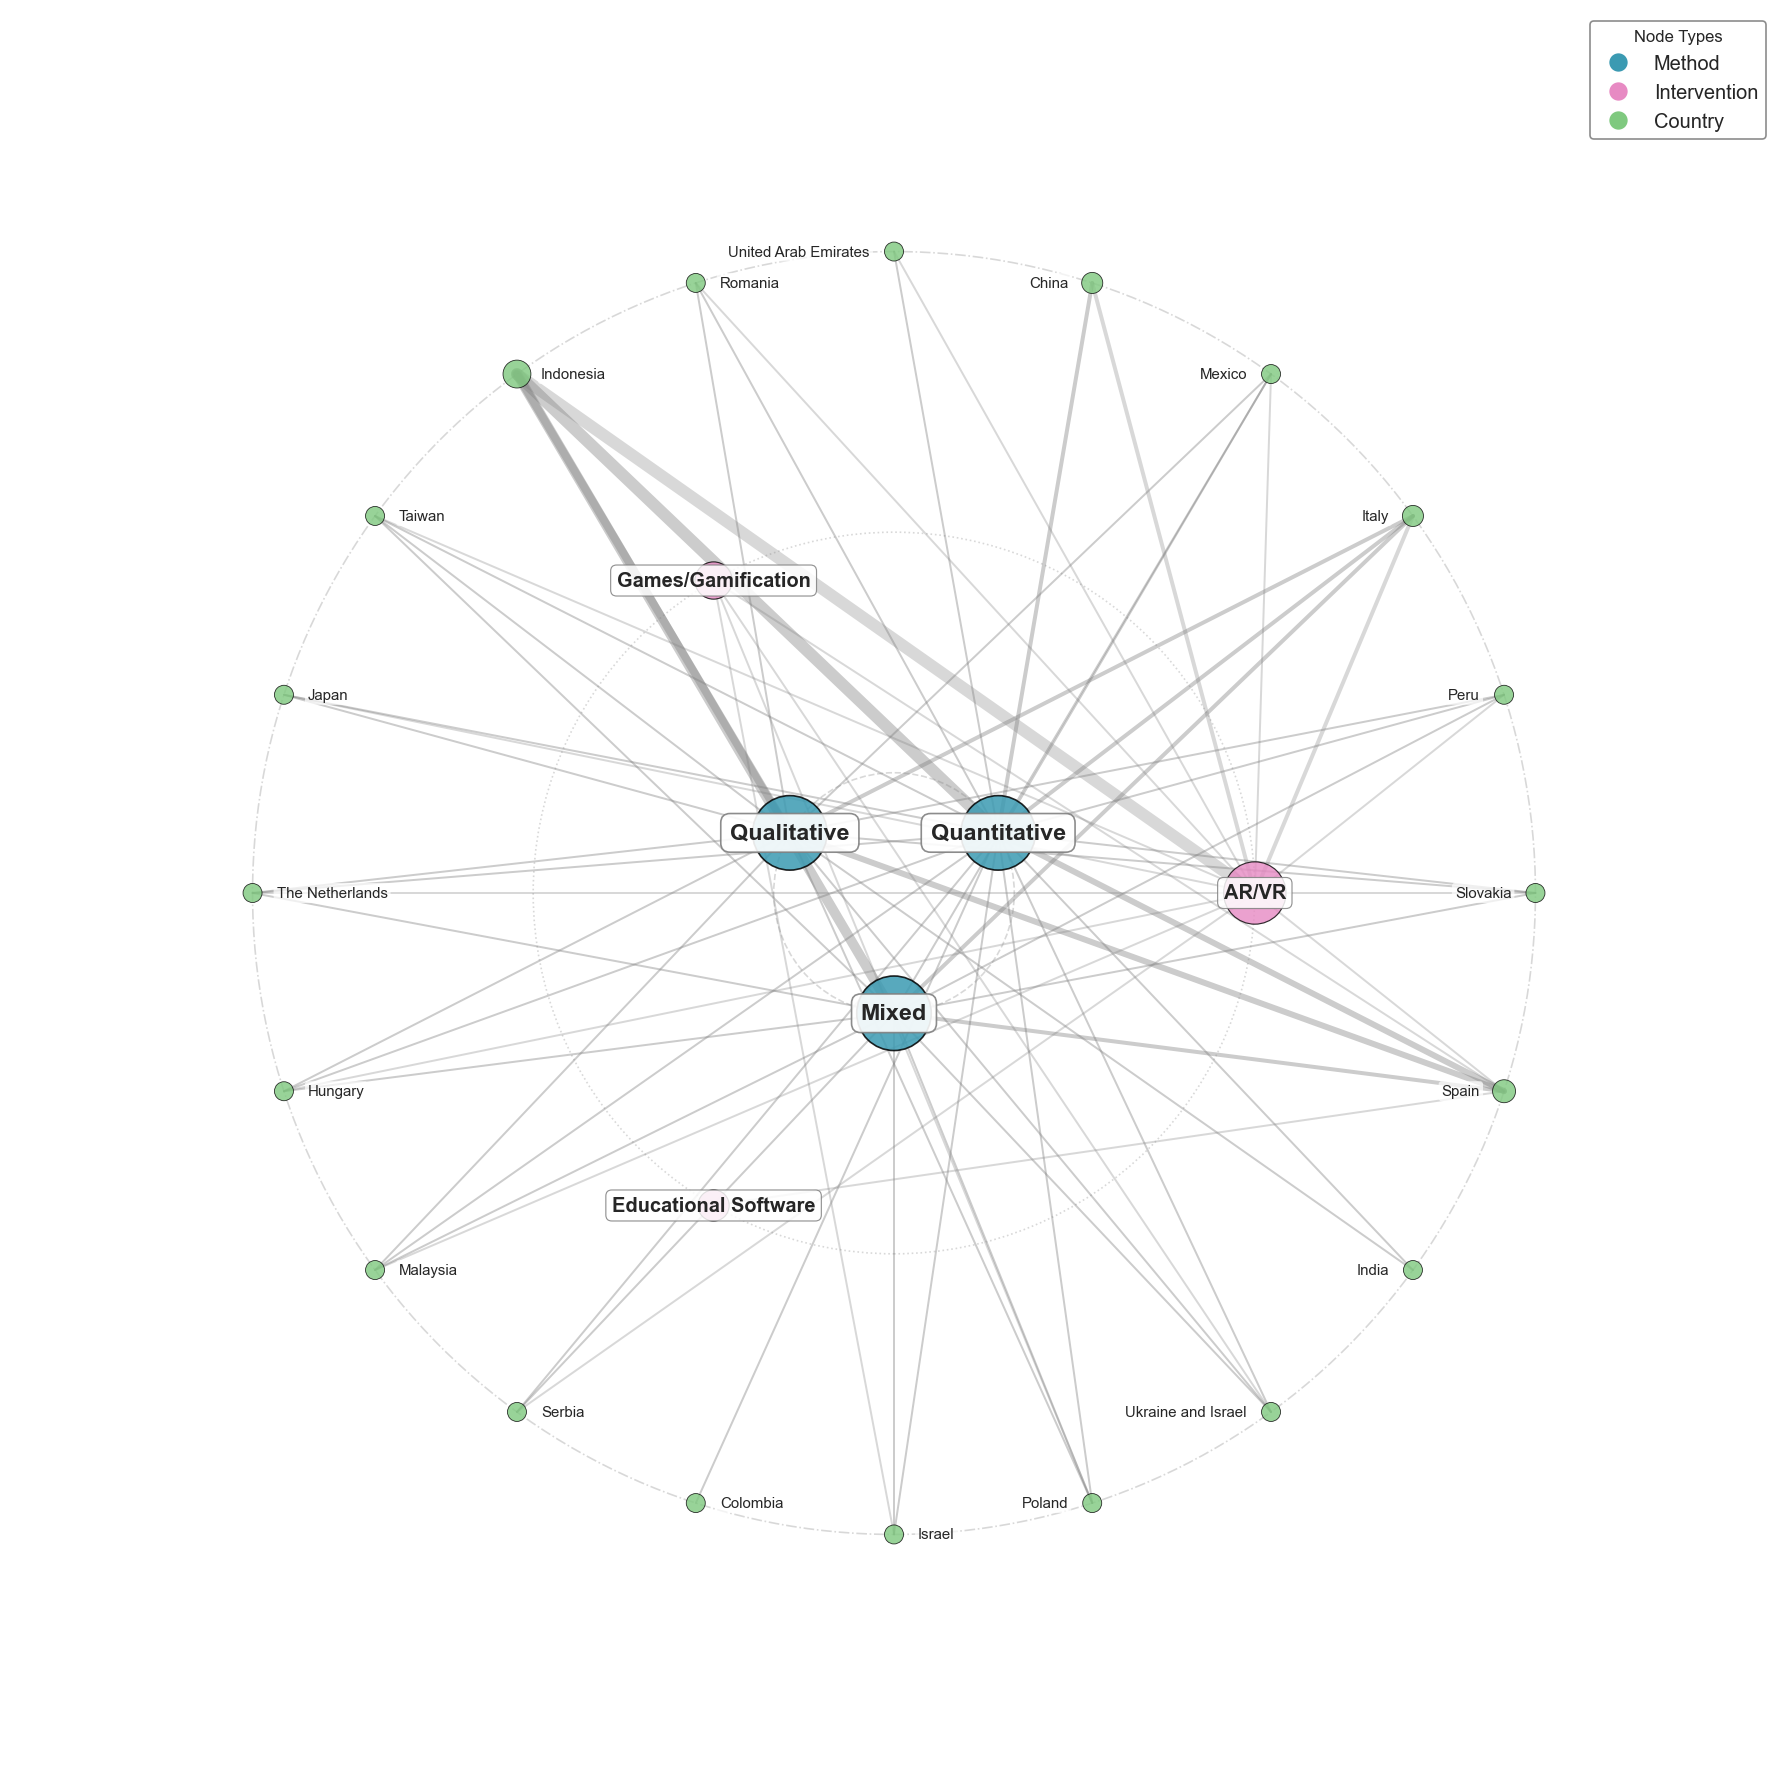

In [29]:
# ============================================================================
# 10. FIGURE 7: ALTERNATIVE STRUCTURED NETWORK VISUALIZATION
# ============================================================================

logging.info("Generating structured concentric network visualization...")

# This visualization shows relationships with a highly structured layout
if all(x in df.columns for x in ['FirstCountry', 'InterventionType']):
    if all(x in df.columns for x in ['Quantitative Methods', 'Qualitative Methods', 'Mixed Methods']):
        # Create a larger figure for better readability
        plt.figure(figsize=(15, 15), facecolor='white')
        
        # Create a network graph
        G = nx.Graph()
        
        # Define node types with academic color scheme
        node_types = {
            'method': '#3b9ab2',      # Teal blue
            'intervention': '#e78ac3', # Soft pink
            'country': '#7fc97f'       # Light green
        }
        
        # Add methodology nodes (central)
        G.add_node('Quantitative', node_type='method')
        G.add_node('Qualitative', node_type='method')
        G.add_node('Mixed', node_type='method')
        
        # Add intervention nodes (middle ring)
        interventions = df['InterventionType'].dropna().unique()
        intervention_nodes = []
        for intervention in interventions:
            if intervention not in ['Not specified', 'Other']:
                G.add_node(intervention, node_type='intervention')
                intervention_nodes.append(intervention)
        
        # Add country nodes (outer ring)
        countries = df['FirstCountry'].dropna().unique()
        country_nodes = []
        for country in countries:
            G.add_node(country, node_type='country')
            country_nodes.append(country)
        
        # Add edges based on co-occurrence in studies
        for _, row in df.iterrows():
            country = row['FirstCountry']
            if pd.isna(country):
                continue
            
            # Connect country to intervention
            if pd.notna(row['InterventionType']) and row['InterventionType'] not in ['Not specified', 'Other']:
                intervention = row['InterventionType']
                if G.has_node(country) and G.has_node(intervention):
                    # Add edge or increment weight if exists
                    if G.has_edge(country, intervention):
                        G[country][intervention]['weight'] += 1
                    else:
                        G.add_edge(country, intervention, weight=1)
            
            # Connect country to methodologies
            for method in ['Quantitative', 'Qualitative', 'Mixed']:
                if pd.notna(row[f'{method} Methods']):
                    if G.has_node(country):
                        if G.has_edge(country, method):
                            G[country][method]['weight'] += 1
                        else:
                            G.add_edge(country, method, weight=1)
        
        # Calculate node importance
        country_counts = df['FirstCountry'].value_counts()
        
        # Node sizes with better scaling
        node_sizes = {}
        
        # Method nodes (large and fixed size)
        for method in ['Quantitative', 'Qualitative', 'Mixed']:
            count = len(df[f'{method} Methods'].dropna())
            node_sizes[method] = 2000  # Fixed large size for methods
        
        # Intervention nodes (medium, scaled by frequency)
        for intervention in intervention_nodes:
            count = len(df[df['InterventionType'] == intervention])
            node_sizes[intervention] = count * 50 + 300
        
        # Country nodes (smaller, scaled by frequency)
        for country in country_nodes:
            count = country_counts.get(country, 0)
            node_sizes[country] = count * 30 + 100
        
        # Calculate edge weights
        edge_widths = {}
        for u, v, d in G.edges(data=True):
            edge_widths[(u, v)] = d.get('weight', 1) * 1.2
            
        # Remove isolated nodes
        isolates = list(nx.isolates(G))
        G.remove_nodes_from(isolates)
        logging.info(f"Removed {len(isolates)} isolated nodes")
        
        if len(G.nodes) > 0:
            # Create highly structured concentric layout
            pos = {}
            
            # Position method nodes in center triangle
            method_radius = 0.15
            for i, method in enumerate(['Quantitative', 'Qualitative', 'Mixed']):
                angle = 2 * np.pi * i / 3 + np.pi/6  # Starting angle slightly offset
                pos[method] = (method_radius * np.cos(angle), method_radius * np.sin(angle))
            
            # Position intervention nodes in middle ring
            intervention_radius = 0.45
            for i, intervention in enumerate(intervention_nodes):
                angle = 2 * np.pi * i / len(intervention_nodes)
                pos[intervention] = (intervention_radius * np.cos(angle), intervention_radius * np.sin(angle))
            
            # Position country nodes in outer ring
            # Sort countries by their connections to get more meaningful layout
            country_connections = {}
            for country in country_nodes:
                # Get connected interventions
                connected_interventions = [n for n in G.neighbors(country) if n in intervention_nodes]
                # Calculate average position of connected interventions
                if connected_interventions:
                    avg_angle = np.mean([np.arctan2(pos[interv][1], pos[interv][0]) for interv in connected_interventions])
                    if avg_angle < 0:
                        avg_angle += 2 * np.pi  # Convert to range [0, 2π]
                    country_connections[country] = avg_angle
                else:
                    # If no connections, assign random angle
                    country_connections[country] = np.random.random() * 2 * np.pi
            
            # Sort countries by their angular position
            countries_sorted = sorted(country_connections.items(), key=lambda x: x[1])
            
            # Place countries equidistantly in the outer ring but influenced by their connections
            country_radius = 0.8
            for i, (country, _) in enumerate(countries_sorted):
                angle = 2 * np.pi * i / len(countries_sorted)
                pos[country] = (country_radius * np.cos(angle), country_radius * np.sin(angle))
            
            # Draw the network by layers (from outside in for better visibility)
            
            # 1. Draw edges with more transparency
            for (u, v, d) in G.edges(data=True):
                # Only draw edges connecting different types
                if G.nodes[u]['node_type'] != G.nodes[v]['node_type']:
                    # Calculate edge width
                    width = edge_widths.get((u, v), 1)
                    
                    # Different transparency based on node types
                    alpha = 0.3
                    if ('method' in [G.nodes[u]['node_type'], G.nodes[v]['node_type']]):
                        alpha = 0.4  # More visible for method connections
                    
                    plt.plot(
                        [pos[u][0], pos[v][0]], 
                        [pos[u][1], pos[v][1]], 
                        color='gray', 
                        linewidth=width,
                        alpha=alpha,
                        zorder=1
                    )
            
            # 2. Draw country nodes (outer ring)
            country_x = [pos[node][0] for node in country_nodes if node in pos]
            country_y = [pos[node][1] for node in country_nodes if node in pos]
            country_s = [node_sizes.get(node, 100) for node in country_nodes if node in pos]
            
            plt.scatter(
                country_x, country_y, 
                s=country_s,
                c=node_types['country'],
                edgecolor='black',
                linewidth=0.5,
                alpha=0.8,
                zorder=2
            )
            
            # 3. Draw intervention nodes (middle ring)
            intervention_x = [pos[node][0] for node in intervention_nodes if node in pos]
            intervention_y = [pos[node][1] for node in intervention_nodes if node in pos]
            intervention_s = [node_sizes.get(node, 300) for node in intervention_nodes if node in pos]
            
            plt.scatter(
                intervention_x, intervention_y, 
                s=intervention_s,
                c=node_types['intervention'],
                edgecolor='black',
                linewidth=0.7,
                alpha=0.8,
                zorder=3
            )
            
            # 4. Draw method nodes (center)
            method_x = [pos[method][0] for method in ['Quantitative', 'Qualitative', 'Mixed'] if method in pos]
            method_y = [pos[method][1] for method in ['Quantitative', 'Qualitative', 'Mixed'] if method in pos]
            method_s = [node_sizes.get(method, 2000) for method in ['Quantitative', 'Qualitative', 'Mixed'] if method in pos]
            
            plt.scatter(
                method_x, method_y, 
                s=method_s,
                c=node_types['method'],
                edgecolor='black',
                linewidth=1.0,
                alpha=0.85,
                zorder=4
            )
            
            # Add labels with differing styles by node type
            # Method labels (largest, bold)
            for method in ['Quantitative', 'Qualitative', 'Mixed']:
                if method in pos:
                    x, y = pos[method]
                    plt.text(
                        x, y, 
                        method, 
                        fontsize=14,
                        fontweight='bold',
                        ha='center', 
                        va='center',
                        bbox=dict(
                            facecolor='white', 
                            alpha=0.9, 
                            edgecolor='gray', 
                            boxstyle='round,pad=0.4',
                            linewidth=1
                        ),
                        zorder=5
                    )
            
            # Intervention labels (medium)
            for intervention in intervention_nodes:
                if intervention in pos:
                    x, y = pos[intervention]
                    plt.text(
                        x, y, 
                        intervention, 
                        fontsize=12,
                        fontweight='bold',
                        ha='center', 
                        va='center',
                        bbox=dict(
                            facecolor='white', 
                            alpha=0.85, 
                            edgecolor='gray',
                            boxstyle='round,pad=0.3',
                            linewidth=0.7
                        ),
                        zorder=5
                    )
            
            # Country labels (smallest)
            for country in country_nodes:
                if country in pos:
                    x, y = pos[country]
                    # Calculate angle to position text outside nodes
                    angle = np.arctan2(y, x)
                    
                    # Adjust text alignment based on position in circle
                    ha = 'left' if x < 0 else 'right'
                    offset = 0.03  # Slight offset for better readability
                    text_x = x + (offset if ha == 'left' else -offset)
                    
                    plt.text(
                        text_x, y, 
                        country, 
                        fontsize=9,
                        ha=ha, 
                        va='center',
                        bbox=dict(
                            facecolor='white', 
                            alpha=0.7, 
                            edgecolor='none',
                            boxstyle='round,pad=0.2'
                        ),
                        zorder=5
                    )
            
            # Add concentric circles to highlight structure
            circle_styles = [
                (0.15, 'gray', 0.3, '--'),  # Method circle
                (0.45, 'gray', 0.3, ':'),   # Intervention circle
                (0.8, 'gray', 0.3, '-.')    # Country circle
            ]
            
            for radius, color, alpha, linestyle in circle_styles:
                circle = plt.Circle((0, 0), radius, fill=False, color=color, 
                                   alpha=alpha, linestyle=linestyle, zorder=0)
                plt.gca().add_patch(circle)
            
            # Create legend for node types
            legend_elements = [
                plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, 
                          markersize=12, label=node_type.capitalize())
                for node_type, color in node_types.items()
            ]
            
            plt.legend(
                handles=legend_elements, 
                loc='upper right',
                title='Node Types',
                frameon=True,
                framealpha=0.9,
                fontsize=12, 
                edgecolor='gray'
            )
            
            # Add title and explanatory text
            #plt.title('Structured Relationship Network', fontsize=16, fontweight='bold')
            #plt.figtext(
            #    0.5, 0.02, 
            #    "Concentric layout shows hierarchical relationships: methods (center),\n" +
            #    "interventions (middle), and countries (outer ring).\n" +
            #    "Node size represents frequency. Edge thickness shows relationship strength.",
            #    ha='center', 
            #    fontsize=10, 
            #    fontstyle='italic'
            #)
            
            # Set equal aspect ratio and remove axes
            plt.gca().set_aspect('equal')
            plt.axis('off')
            
            # Set axis limits (slightly larger than circle)
            plt.xlim(-1.1, 1.1)
            plt.ylim(-1.1, 1.1)
            
            # Save figure
            save_figure(plt.gcf(), "figure7_concentric_networkv2", dpi=200)
            
            logging.info("Concentric network visualization completed.")
        else:
            logging.warning("Network has no nodes after processing. Check your data.")
    else:
        logging.warning("Methodology columns missing for network visualization.")
else:
    logging.warning("Required columns missing for network visualization.")

2025-05-10 12:39:04,633 - INFO - Generating optimized relationship network with complete author information...
2025-05-10 12:39:04,651 - INFO - Removed 0 isolated nodes
2025-05-10 12:39:04,654 - WARNING - Using fallback circular layout due to layout computation issue
2025-05-10 12:39:06,315 - INFO - Figure saved as figure7_optimized_networkv2.{png,pdf,svg}
2025-05-10 12:39:06,316 - INFO - Enhanced optimized network visualization completed.


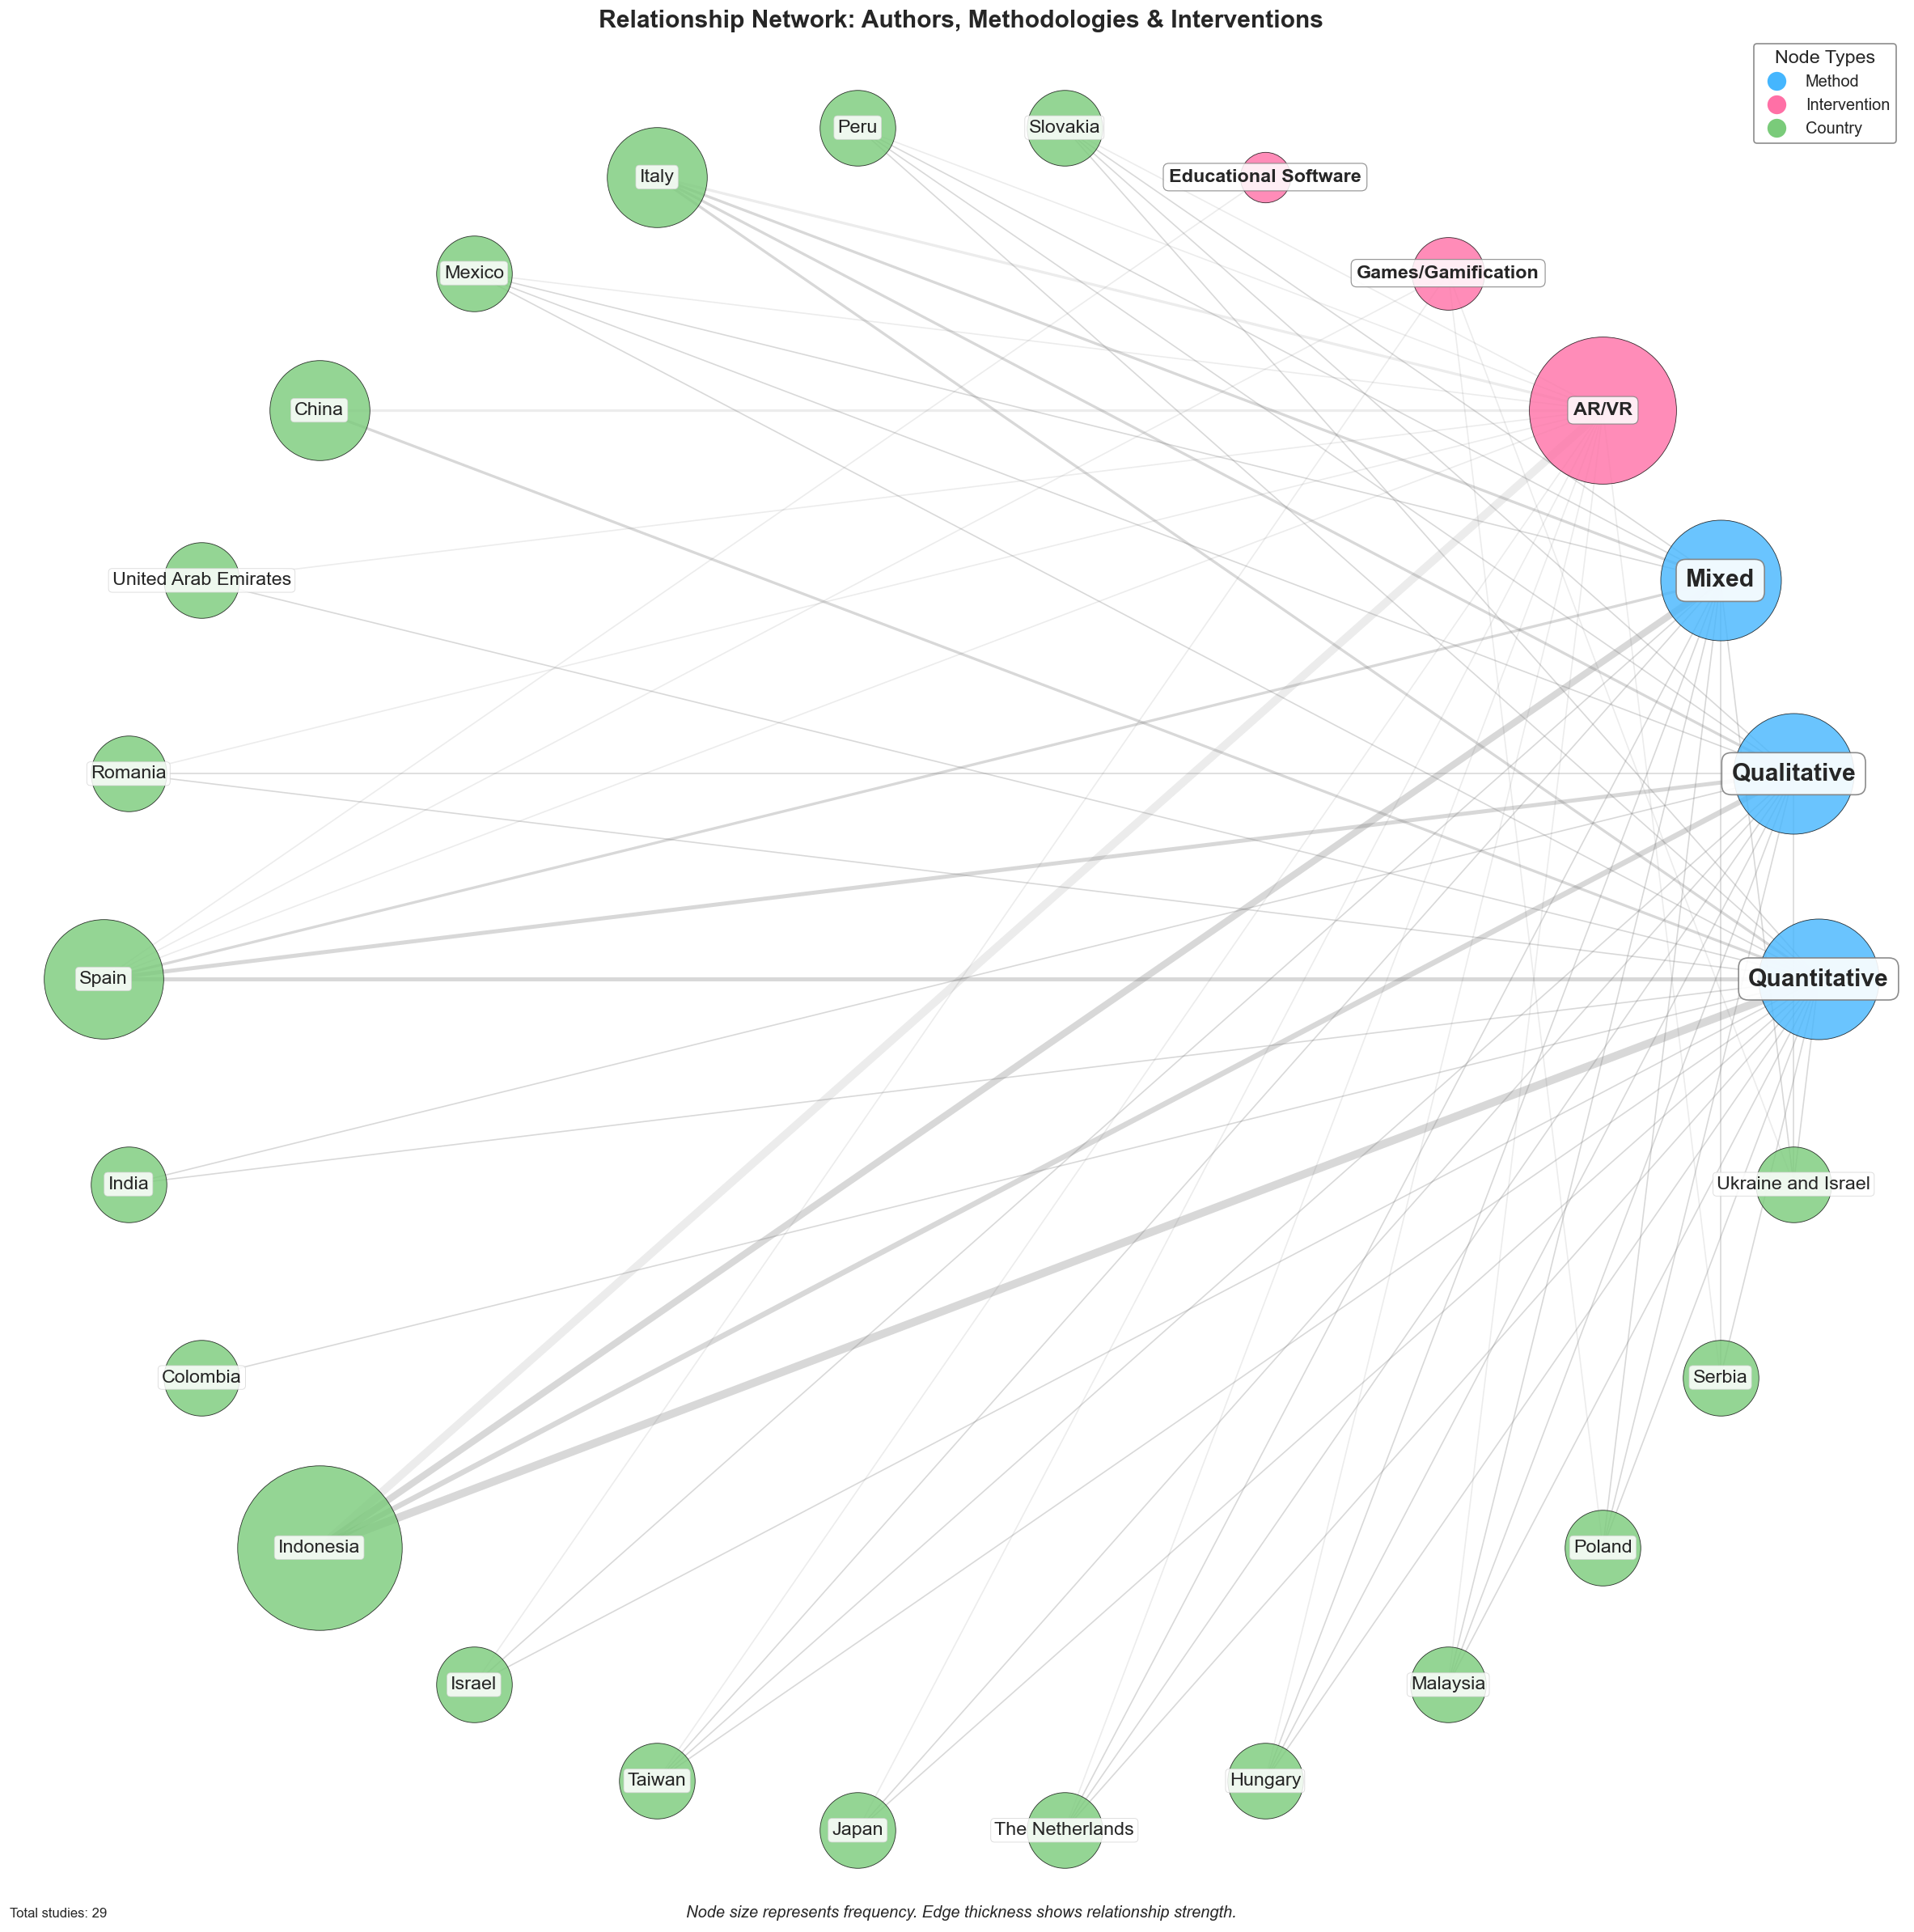

In [47]:
# ============================================================================
# 10. FIGURE 7: RELATIONSHIP NETWORK WITH OPTIMIZED LAYOUT
# ============================================================================

logging.info("Generating optimized relationship network with complete author information...")

# This visualization uses a better layout algorithm and ensures complete author information
if all(x in df.columns for x in ['FirstCountry', 'InterventionType']):
    if all(x in df.columns for x in ['Quantitative Methods', 'Qualitative Methods', 'Mixed Methods']):
        # Create figure with better aspect ratio
        plt.figure(figsize=(20, 20), facecolor='white')
        
        # Create a network graph
        G = nx.Graph()
        
        # Define node types with academic color scheme
        node_types = {
            'method': '#45b6fe',      # Bright blue
            'intervention': '#ff70a6', # Pink
            'country': '#7acb7a'       # Bright green
        }
        
        # Add methodology nodes
        G.add_node('Quantitative', node_type='method')
        G.add_node('Qualitative', node_type='method')
        G.add_node('Mixed', node_type='method')
        
        # Add intervention nodes
        interventions = df['InterventionType'].dropna().unique()
        for intervention in interventions:
            if intervention not in ['Not specified', 'Other']:
                G.add_node(intervention, node_type='intervention')
        
        # Process author information
        author_info = {}
        
        # Check if we have Author and Year columns
        has_author_column = 'Authors' in df.columns
        has_year_column = 'Year' in df.columns
        
        
        
        # Add country nodes with full author info
        countries = df['FirstCountry'].dropna().unique()
        for country in countries:
            # Use complete label if available, otherwise just country
            node_label = author_info.get(country, country)
            G.add_node(node_label, node_type='country', base_country=country)
        
        # Add edges based on co-occurrence
        for _, row in df.iterrows():
            country = row['FirstCountry']
            if pd.isna(country):
                continue
            
            # Get country node with author info
            country_node = author_info.get(country, country)
            
            # Connect country to intervention
            if pd.notna(row['InterventionType']) and row['InterventionType'] not in ['Not specified', 'Other']:
                intervention = row['InterventionType']
                if G.has_node(country_node) and G.has_node(intervention):
                    # Add edge or increment weight if exists
                    if G.has_edge(country_node, intervention):
                        G[country_node][intervention]['weight'] += 1
                    else:
                        G.add_edge(country_node, intervention, weight=1)
            
            # Connect country to methodologies
            for method in ['Quantitative', 'Qualitative', 'Mixed']:
                if pd.notna(row[f'{method} Methods']):
                    if G.has_node(country_node):
                        if G.has_edge(country_node, method):
                            G[country_node][method]['weight'] += 1
                        else:
                            G.add_edge(country_node, method, weight=1)
        
        # Calculate node importance
        country_counts = {}
        for node in G.nodes():
            if G.nodes[node]['node_type'] == 'country':
                base_country = G.nodes[node].get('base_country', node)
                country_counts[node] = len(df[df['FirstCountry'] == base_country])
        
        # Calculate node sizes
        node_sizes = {}
        
        # Method nodes (large fixed size)
        for method in ['Quantitative', 'Qualitative', 'Mixed']:
            if method in G.nodes():
                node_sizes[method] = 8000
        
        # Intervention nodes (scaled by frequency)
        for node in G.nodes():
            if G.nodes[node]['node_type'] == 'intervention':
                count = len(df[df['InterventionType'] == node])
                node_sizes[node] = count * 500 + 900
        
        # Country nodes (scaled by frequency)
        for node in G.nodes():
            if G.nodes[node]['node_type'] == 'country':
                base_country = G.nodes[node].get('base_country', node)
                count = len(df[df['FirstCountry'] == base_country])
                node_sizes[node] = count * 2350 + 800
        
        # Calculate edge widths
        edge_widths = {}
        for u, v, d in G.edges(data=True):
            edge_widths[(u, v)] = d.get('weight', 1) * 1.0
        
        # Remove isolated nodes
        isolates = list(nx.isolates(G))
        G.remove_nodes_from(isolates)
        logging.info(f"Removed {len(isolates)} isolated nodes")
        
        if len(G.nodes) > 0:
            # Use Fruchterman-Reingold layout with careful tuning for better spacing
            try:
                # Add small random positions to avoid overlaps due to exact center positioning
                pos_init = {node: (np.random.uniform(-0.01, 0.01), np.random.uniform(-0.01, 0.01)) 
                           if G.nodes[node]['node_type'] == 'method' else None 
                           for node in G.nodes()}
                
                # Use Fruchterman-Reingold with careful parameter tuning
                pos = nx.spring_layout(
                    G, 
                    k=0.8,           # Higher k means more space between nodes
                    iterations=150,  # More iterations for convergence
                    seed=42,         # Fixed seed for reproducibility
                    pos=pos_init,    # Initialize methods near center
                    scale=0.1        # Scale to use more space
                )
                
                # Adjust method positions for better triangle formation
                method_pos = {}
                methods = ['Quantitative', 'Qualitative', 'Mixed']
                methods_in_graph = [m for m in methods if m in G.nodes()]
                
                if len(methods_in_graph) == 3:
                    # Place methods in a triangle
                    r = 2  # Small radius
                    angles = [0, 2*np.pi/3, 4*np.pi/3]  # Triangle angles
                    for i, method in enumerate(methods_in_graph):
                        method_pos[method] = (r * np.cos(angles[i]), r * np.sin(angles[i]))
                        
                # Update positions
                pos.update(method_pos)
                
                # Normalize positions to ensure they fit well in the figure
                max_dim = max(max(abs(x) for x, y in pos.values()), max(abs(y) for x, y in pos.values()))
                if max_dim > 0:
                    scale_factor = 0.9 / max_dim  # Scale to fit in [-0.9, 0.9]
                    pos = {node: (x * scale_factor, y * scale_factor) for node, (x, y) in pos.items()}
            except:
                # Fallback to simpler layout
                pos = nx.circular_layout(G)
                logging.warning("Using fallback circular layout due to layout computation issue")
            
            # Draw the network elements in specific order (edges first, then nodes, then labels)
            
            # 1. Draw edges
            for (u, v, d) in G.edges(data=True):
                # Get node types for each endpoint
                u_type = G.nodes[u]['node_type']
                v_type = G.nodes[v]['node_type']
                
                # Calculate edge width
                width = edge_widths.get((u, v), 1)
                
                # Set alpha based on connection type
                alpha = 0.15  # Default transparency
                if 'method' in [u_type, v_type]:
                    alpha = 0.3  # More visible for method connections
                
                plt.plot(
                    [pos[u][0], pos[v][0]], 
                    [pos[u][1], pos[v][1]], 
                    color='gray', 
                    linewidth=width,
                    alpha=alpha,
                    zorder=1  # Draw edges below nodes
                )
            
            # 2. Draw nodes by type from largest to smallest
            node_types_order = ['method', 'intervention', 'country']  # Draw methods first, countries last
            
            for node_type in node_types_order:
                nodes = [node for node in G.nodes() if G.nodes[node]['node_type'] == node_type]
                color = node_types[node_type]
                
                # Draw nodes of this type
                for node in nodes:
                    size = node_sizes.get(node, 600)
                    plt.scatter(
                        pos[node][0], pos[node][1],
                        s=size,
                        c=color,
                        edgecolor='black',
                        linewidth=0.5,
                        alpha=0.8,
                        zorder=2  # Above edges, below labels
                    )
            
            # 3. Draw labels with improved formatting
            for node in G.nodes():
                x, y = pos[node]
                node_type = G.nodes[node]['node_type']
                
                # Skip tiny nodes (if any)
                if node_sizes.get(node, 0) < 100:
                    continue
                    
                # Different label styles by node type
                if node_type == 'method':
                    # Method labels - large, bold, centered
                    plt.text(
                        x, y, 
                        node, 
                        fontsize=18,
                        fontweight='bold',
                        ha='center', 
                        va='center',
                        bbox=dict(
                            facecolor='white', 
                            alpha=0.9, 
                            edgecolor='gray', 
                            boxstyle='round,pad=0.4',
                            linewidth=1
                        ),
                        zorder=4  # Top layer
                    )
                elif node_type == 'intervention':
                    # Intervention labels - medium size
                    plt.text(
                        x, y, 
                        node, 
                        fontsize=14,
                        fontweight='bold',
                        ha='center', 
                        va='center',
                        bbox=dict(
                            facecolor='white', 
                            alpha=0.85, 
                            edgecolor='gray',
                            boxstyle='round,pad=0.3',
                            linewidth=0.7
                        ),
                        zorder=3
                    )
                else:  # country with author info
                    # Country labels - smaller
                    plt.text(
                        x, y, 
                        node, 
                        fontsize=14,
                        ha='center', 
                        va='center',
                        bbox=dict(
                            facecolor='white', 
                            alpha=0.85, 
                            edgecolor='lightgray',
                            boxstyle='round,pad=0.2',
                            linewidth=0.5
                        ),
                        zorder=3
                    )
            
            # Add legend for node types
            legend_elements = [
                plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, 
                          markersize=15, label=node_type.capitalize())
                for node_type, color in node_types.items()
            ]
            
            plt.legend(
                handles=legend_elements, 
                loc='upper right',
                title='Node Types',
                fontsize=12,
                title_fontsize=14,
                frameon=True,
                framealpha=0.9,
                edgecolor='gray'
            )
            
            # Add title and explanatory note
            plt.title('Relationship Network: Authors, Methodologies & Interventions', fontsize=18, fontweight='bold')
            plt.figtext(
                0.5, 0.01, 
                "Node size represents frequency. Edge thickness shows relationship strength.",
                ha='center', 
                fontsize=12, 
                fontstyle='italic'
            )
            
            # Set equal aspect ratio and hide axes
            plt.axis('off')
            plt.gca().set_aspect('equal')
            
            # Set limits with sufficient margin
            plt.xlim(-1.1, 1.1)
            plt.ylim(-1.1, 1.1)
            
            # Add additional information
            plt.figtext(
                0.01, 0.01, 
                f"Total studies: {len(df)}", 
                ha='left', 
                fontsize=10
            )
            
            # Tight layout
            plt.tight_layout()
            
            # Save figure with high resolution
            save_figure(plt.gcf(), "figure7_optimized_networkv2", dpi=200)
            
            logging.info("Enhanced optimized network visualization completed.")
        else:
            logging.warning("Network has no nodes after processing. Check your data.")
    else:
        logging.warning("Methodology columns missing for network visualization.")
else:
    logging.warning("Required columns missing for network visualization.")

2025-05-10 12:46:37,430 - INFO - Generating relationship network with correct author labels...
2025-05-10 12:46:37,466 - INFO - Removed 0 isolated nodes
2025-05-10 12:46:41,835 - INFO - Figure saved as figure7_relationship_network_corrected.{png,pdf,svg}
2025-05-10 12:46:41,836 - INFO - Corrected relationship network visualization completed.


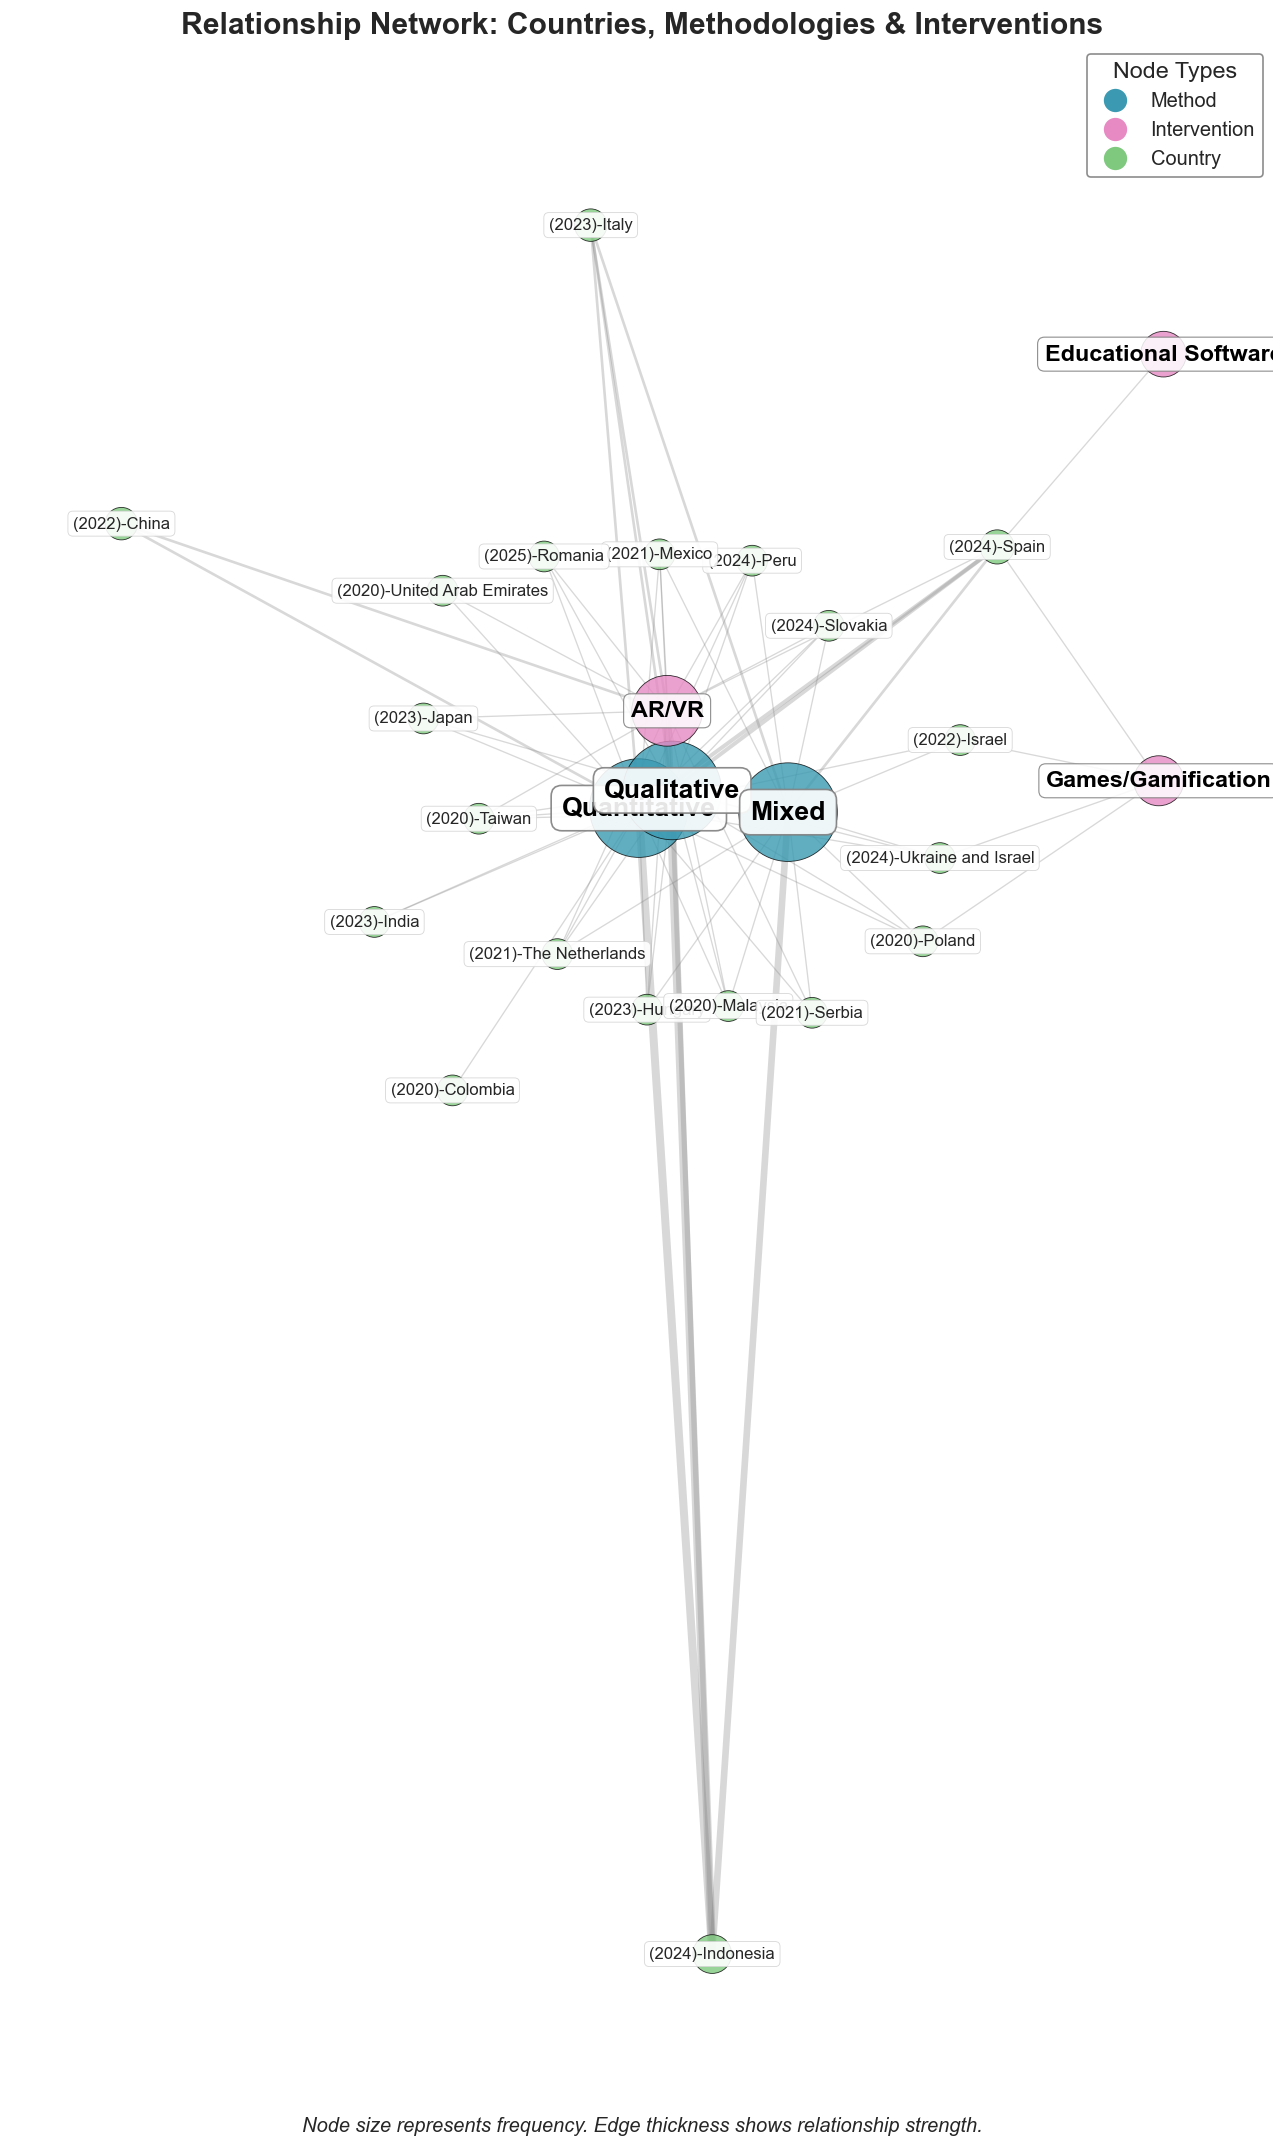

In [48]:
# ============================================================================
# 10. FIGURE 7: RELATIONSHIP NETWORK WITH CORRECT AUTHOR LABELS
# ============================================================================

logging.info("Generating relationship network with correct author labels...")

# This visualization ensures all author information is correctly displayed
if all(x in df.columns for x in ['FirstCountry', 'InterventionType']):
    if all(x in df.columns for x in ['Quantitative Methods', 'Qualitative Methods', 'Mixed Methods']):
        # Create a larger figure for better visibility
        plt.figure(figsize=(18, 18), facecolor='white')
        
        # Create a network graph
        G = nx.Graph()
        
        # Define node types with academic color scheme for better differentiation
        node_types = {
            'method': '#3b9ab2',      # Teal blue
            'intervention': '#e78ac3', # Pink
            'country': '#7fc97f'       # Light green
        }
        
        # Add methodology nodes
        G.add_node('Quantitative', node_type='method')
        G.add_node('Qualitative', node_type='method')
        G.add_node('Mixed', node_type='method')
        
        # Add intervention nodes
        interventions = df['InterventionType'].dropna().unique()
        for intervention in interventions:
            if intervention not in ['Not specified', 'Other']:
                G.add_node(intervention, node_type='intervention')
        
        # Process author and country information more carefully
        author_country_nodes = {}
        
        # Check which columns we have available
        has_author_column = 'Author' in df.columns
        has_year_column = 'Year' in df.columns
        
        # Create a dictionary to store all rows for each country
        country_data = {}
        
        # Group rows by country
        for _, row in df.iterrows():
            country = row['FirstCountry']
            if pd.isna(country):
                continue
                
            if country not in country_data:
                country_data[country] = []
            country_data[country].append(row)
        
        # Process each country to extract author information
        for country, rows in country_data.items():
            # For each country, we'll use the first non-NaN author info
            author = None
            year = None
            
            # First try to find a row with both author and year
            for row in rows:
                if has_author_column and has_year_column:
                    if pd.notna(row['Author']) and pd.notna(row['Year']):
                        author = row['Author']
                        year = str(int(row['Year']))
                        break
            
            # If we didn't find a complete row, look for partial info
            if author is None and year is None:
                for row in rows:
                    if has_author_column and pd.notna(row['Author']):
                        author = row['Author']
                    if has_year_column and pd.notna(row['Year']):
                        year = str(int(row['Year']))
                    if author is not None and year is not None:
                        break
            
            # Use available info, never defaulting to "Unknown"
            if author is not None and year is not None:
                node_label = f"({author}-{year})-{country}"
            elif author is not None:
                node_label = f"({author})-{country}"
            elif year is not None:
                node_label = f"({year})-{country}"
            else:
                node_label = country
            
            # Store mapping and add node
            author_country_nodes[country] = node_label
            G.add_node(node_label, node_type='country', base_country=country)
        
        # Add edges based on co-occurrence in studies
        for _, row in df.iterrows():
            country = row['FirstCountry']
            if pd.isna(country):
                continue
            
            # Get the correct node label for this country
            country_node = author_country_nodes.get(country, country)
            
            # Connect country to intervention
            if pd.notna(row['InterventionType']) and row['InterventionType'] not in ['Not specified', 'Other']:
                intervention = row['InterventionType']
                if G.has_node(country_node) and G.has_node(intervention):
                    # Add edge or increment weight if exists
                    if G.has_edge(country_node, intervention):
                        G[country_node][intervention]['weight'] += 1
                    else:
                        G.add_edge(country_node, intervention, weight=1)
            
            # Connect country to methodologies
            for method in ['Quantitative', 'Qualitative', 'Mixed']:
                if pd.notna(row[f'{method} Methods']):
                    if G.has_node(country_node):
                        if G.has_edge(country_node, method):
                            G[country_node][method]['weight'] += 1
                        else:
                            G.add_edge(country_node, method, weight=1)
        
        # Calculate node sizes
        node_sizes = {}
        
        # Method nodes (large fixed size)
        method_sizes = {
            'Quantitative': 3500,
            'Qualitative': 3500,
            'Mixed': 3500
        }
        node_sizes.update(method_sizes)
        
        # Intervention nodes (scaled by frequency)
        for intervention in interventions:
            if intervention not in ['Not specified', 'Other'] and G.has_node(intervention):
                count = len(df[df['InterventionType'] == intervention])
                node_sizes[intervention] = count * 50 + 700
        
        # Country nodes (scaled by frequency)
        for node, data in G.nodes(data=True):
            if data['node_type'] == 'country':
                base_country = data.get('base_country', node)
                count = len(df[df['FirstCountry'] == base_country])
                node_sizes[node] = count * 40 + 300
        
        # Calculate edge weights
        edge_weights = []
        for u, v, d in G.edges(data=True):
            edge_weights.append(d.get('weight', 1) * 0.8)
        
        # Remove isolated nodes
        isolates = list(nx.isolates(G))
        G.remove_nodes_from(isolates)
        logging.info(f"Removed {len(isolates)} isolated nodes")
        
        # Create a structured layout
        if len(G.nodes) > 0:
            try:
                # Try Kamada-Kawai for better spacing
                pos = nx.kamada_kawai_layout(G, scale=1.5)
            except:
                # Fallback to spring layout with better parameters
                pos = nx.spring_layout(
                    G, 
                    k=1.5,           # Higher k means more space between nodes
                    iterations=100,  # More iterations for better convergence
                    seed=42,         # Fixed seed for reproducibility
                    scale=1.5        # Scale to use more space
                )
            
            # Draw edges with reduced opacity
            nx.draw_networkx_edges(
                G, pos,
                width=edge_weights,
                alpha=0.3,
                edge_color='gray'
            )
            
            # Draw nodes by type
            for node_type, color in node_types.items():
                # Get nodes of this type
                nodes = [node for node, data in G.nodes(data=True) if data.get('node_type') == node_type]
                # Get sizes for these nodes
                sizes = [node_sizes.get(node, 300) for node in nodes]
                
                nx.draw_networkx_nodes(
                    G, pos, 
                    nodelist=nodes,
                    node_size=sizes,
                    node_color=color,
                    alpha=0.8,
                    edgecolors='black',
                    linewidths=0.5
                )
            
            # Draw labels with improved visibility
            # Separate labels by node type for better control
            for node_type in ['method', 'intervention', 'country']:
                nodes = [node for node, data in G.nodes(data=True) if data.get('node_type') == node_type]
                
                # Different label styles for different node types
                if node_type == 'method':
                    # Method labels (largest, bold)
                    method_labels = {node: node for node in nodes}
                    nx.draw_networkx_labels(
                        G, pos,
                        labels=method_labels,
                        font_size=16,
                        font_weight='bold',
                        bbox=dict(
                            facecolor='white', 
                            alpha=0.9, 
                            edgecolor='gray', 
                            boxstyle='round,pad=0.4',
                            linewidth=1
                        )
                    )
                elif node_type == 'intervention':
                    # Intervention labels (medium size)
                    intervention_labels = {node: node for node in nodes}
                    nx.draw_networkx_labels(
                        G, pos,
                        labels=intervention_labels,
                        font_size=14,
                        font_weight='bold',
                        bbox=dict(
                            facecolor='white', 
                            alpha=0.85, 
                            edgecolor='gray',
                            boxstyle='round,pad=0.3',
                            linewidth=0.7
                        )
                    )
                else:
                    # Country labels (smaller size)
                    # Custom label drawing to handle long labels better
                    for node in nodes:
                        x, y = pos[node]
                        plt.text(
                            x, y, 
                            node, 
                            fontsize=10,
                            ha='center', 
                            va='center',
                            bbox=dict(
                                facecolor='white', 
                                alpha=0.9, 
                                edgecolor='lightgray',
                                boxstyle='round,pad=0.3',
                                linewidth=0.5
                            )
                        )
            
            # Create legend for node types
            legend_elements = [
                plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, 
                          markersize=15, label=node_type.capitalize())
                for node_type, color in node_types.items()
            ]
            
            plt.legend(
                handles=legend_elements, 
                loc='upper right',
                title='Node Types',
                fontsize=12,
                title_fontsize=14,
                frameon=True,
                framealpha=0.9,
                edgecolor='gray'
            )
            
            # Add title and explanatory text
            plt.title('Relationship Network: Countries, Methodologies & Interventions', fontsize=18, fontweight='bold')
            plt.figtext(
                0.5, 0.01, 
                "Node size represents frequency. Edge thickness shows relationship strength.",
                ha='center', 
                fontsize=12, 
                fontstyle='italic'
            )
            
            # Set equal aspect ratio and remove axes
            plt.axis('off')
            plt.gca().set_aspect('equal')
            
            # Save figure
            save_figure(plt.gcf(), "figure7_relationship_network_corrected", dpi=800)
            
            logging.info("Corrected relationship network visualization completed.")
        else:
            logging.warning("Network has no nodes after processing. Check your data.")
    else:
        logging.warning("Methodology columns missing for network visualization.")
else:
    logging.warning("Required columns missing for network visualization.")